# Описание проекта: промышленность


Для оптимизации производственных расходов, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

Хорошей партией считается партия, имеющая две и более замеров температур. Некачественные партии (с одним замером температуры) использовать не нужно. 

Задача — построить модель, которая будет предсказывать последнюю температуру сплава партии. Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

Для подбора признаков для модели, а также генерирования новых признаков, необходимо понимание деталей технологического процесса обработки стали. Важно: объединение таблиц должно происходить по ключам, которые есть во всех таблицах.



**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

В технической документации для легированной стали диапазон температур начинается с 1320. Все что ниже этого уровня - процесс изготовления чугуна. Заказчик чугуном не занимается.

**Цель исследования:** 

1. Построить модель машинного обучения, которая будет предсказывать последнюю температуру сплава партии: решаем задачу регрессии;
2. Метрика МАЕ лучшей модели на тестовых данных не более 6.8

**Ход исследования:**

- Загрузка данных и первичный осмотр.
- Исследовательский анализ и предобработка данных. 
- Отбор входящих признаков и объединение выбранных признаков в один датафрейм по ключу.
- Исследовательский анализ и предобработка данных объединённого датафрейма. Визуализация распределения признаков. Проведение корреляционного анализа признаков. 
- Подготовка данных для обучения моделей. Обучение моделей машинного обучения и выбор лучшей модели.
- Общий вывод и рекомендации заказчику.

## Загрузка данных и первичный осмотр.

In [1]:
# Установим актуальную версию библиотеки sklearn
!pip install -U scikit-learn -q

# Установим библиотеку optuna
!pip install optuna -q

!pip install optuna-integration\[sklearn\] -q

In [2]:
# Импортируем библиотеку pandas для работы с датафреймом
import pandas as pd

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем библиотеку seaborn для построения графиков
import seaborn as sns

# Импортируем библиотеку numpy  для математических операций 
import numpy as np

# Импортируем функцию train_test_split для разделения данных
from sklearn.model_selection import train_test_split

# Импортируем класс pipeline для работы с пайплайнами
from sklearn.pipeline import Pipeline

# Импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV

# Импортируем библиотеку Optuna
import optuna

# Импортируем OptunaSearchCV 
from optuna.integration import OptunaSearchCV 

# Импортируем модуль distributions
from optuna import distributions

# Импортируем: 
# класс StandardScaler для стандартизации данных
# класс MinMaxScaler для нормализации данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Импортируем:
# класс LinearRegression для линейной регрессии
# класс DecisionTreeRegressor для дерева решений
# класс DummyRegressor константная модель
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

# Импортируем библиотеку lightgbm для модели LightGBM
import lightgbm as lgb

# Импортируем метрики
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Зададим переменную Randon_state
RANDOM_STATE = 280725

Загрузим данные в датафреймы `pandas`.

In [4]:
# Столбцы с датой и временем преобразуем сразу в нужный формат
data_arc = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_industry/data_files/data_arc_new.csv', 
                       parse_dates=['Начало нагрева дугой', 
                                    'Конец нагрева дугой'])

In [5]:
data_bulk = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_industry/data_files/data_bulk_new.csv')

In [6]:
# Столбцы с датой и временем преобразуем сразу в нужный формат
data_bulk_time = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_industry/data_files/data_bulk_time_new.csv', 
                             parse_dates=['Bulk 1', 'Bulk 2', 'Bulk 3', 
                                          'Bulk 4', 'Bulk 5', 'Bulk 6', 
                                          'Bulk 7', 'Bulk 8', 'Bulk 9', 
                                          'Bulk 10', 'Bulk 11', 'Bulk 12', 
                                          'Bulk 13', 'Bulk 14', 'Bulk 15'])

In [7]:
data_gas = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_industry/data_files/data_gas_new.csv')

In [8]:
# Столбцец с датой и временем преобразуем сразу в нужный формат
data_temp = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_industry/data_files/data_temp_new.csv', 
                        parse_dates=['Время замера'])

In [9]:
data_wire = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_industry/data_files/data_wire_new.csv')

In [10]:
# Столбцы с датой и временем преобразуем сразу в нужный формат
data_wire_time = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_industry/data_files/data_wire_time_new.csv', 
                             parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 
                                          'Wire 4', 'Wire 5', 'Wire 6', 
                                          'Wire 7', 'Wire 8', 'Wire 9'])

In [11]:
# Напишем собственную функцию, которая будет выводить:
# информацию о датасете
# первые 5 строк 
# кол-во пропущенных значений 
# явные дубликаты

def df_info(data):
    info = data.info()
    head = data.head()
    miss = pd.DataFrame(data.isna().sum()).T.style.background_gradient('coolwarm')
    duplicate = data[data.duplicated()]
    return info, display(miss, duplicate, head)

### Рассмотрим датасет `data_arc`.

In [12]:
# Применим к датасету функцию df_info()
df_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Empty DataFrame
Columns: [key, Начало нагрева дугой, Конец нагрева дугой, Активная мощность, Реактивная мощность]
Index: []

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

(None, None)

Датасет `data_arc` содержит данные об электродах со следующими столбцами:

- `key` — номер партии;
- `Начало нагрева дугой` — время начала нагрева;
- `Конец нагрева дугой` — время окончания нагрева;
- `Активная мощность` — значение активной мощности;
- `Реактивная мощность` — значение реактивной мощности.

В датасете отсутствуют пропуски и явные дубликаты. Строки с одинаковым значением столбца `key`, соответствуют разным итерациям обработки.

In [13]:
# Приведем наименования столбцов к змеиному регистру.
data_arc = data_arc.rename(
    columns={
        'Начало нагрева дугой': 'begin_heat', 
        'Конец нагрева дугой': 'end_heat', 
        'Активная мощность': 'active_power', 
        'Реактивная мощность': 'reactive_power'
    }
)

# Выведем список с названиями столбцов
data_arc.columns

Index(['key', 'begin_heat', 'end_heat', 'active_power', 'reactive_power'], dtype='object')

### Рассмотрим датасет `data_bulk`.

In [14]:
# Применим к датасету функцию df_info()
df_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


Empty DataFrame
Columns: [key, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15]
Index: []

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

(None, None)

Датасет `data_bulk` содержит данные о подаче сыпучих материалов (объём) со следующими столбцами:

- `key` — номер партии;
- `Bulk 1 … Bulk 15` — объём подаваемого материала.

В датасете отсутствуют явные дубликаты. Имеются пропуски в столбцах с `Bulk 1` по `Bulk 15`. Это может означать, что в различные партии добавляют определнный тип сыпучих материалов. 

In [15]:
# Приведем наименования столбцов к змеиному регистру.
data_bulk = data_bulk.rename(
    columns={
        'Bulk 1': 'bulk_1', 'Bulk 2': 'bulk_2', 'Bulk 3': 'bulk_3', 
        'Bulk 4': 'bulk_4', 'Bulk 5': 'bulk_5', 'Bulk 6': 'bulk_6', 
        'Bulk 7': 'bulk_7', 'Bulk 8': 'bulk_8', 'Bulk 9': 'bulk_9', 
        'Bulk 10': 'bulk_10', 'Bulk 11': 'bulk_11', 'Bulk 12': 'bulk_12', 
        'Bulk 13': 'bulk_13', 'Bulk 14': 'bulk_14', 'Bulk 15': 'bulk_15'
    }
)

# Выведем список с названиями столбцов
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

### Рассмотрим датасет `data_bulk_time`.

In [16]:
# Применим к датасету функцию df_info()
df_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB


Empty DataFrame
Columns: [key, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15]
Index: []

key Bulk 1 Bulk 2 Bulk 3              Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:32:39    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:43:22    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:30:47    NaT    NaT    NaT    NaT   

  Bulk 9 Bulk 10 Bulk 11             Bulk 12 Bulk 13             Bulk 14  \
0    NaT     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50   
1    NaT     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   
2    NaT     NaT     NaT 2019-05-03 12:27:13     NaT 2019-05-03 12:21:01   
3    NaT     NaT     NaT 2019-05-03 12:58:00     NaT 2019-05-03 12:51:11   
4    NaT     NaT     NaT 2019-05-03 13:30:47     NaT 2019-05-03 13:34:12   

              Bulk 15  
0 2019-05-03 11:10:43  
1 2019-05-03 11:44:39  
2 2019-05-03 12:16:16  
3 2019-05-03 12:46:36  
4 2019-05-03 13:30:47

(None, None)

Датасет `data_bulk_time` содержит данные о подаче сыпучих материалов (время) со следующими столбцами:

- `key` — номер партии;
- `Bulk 1 … Bulk 15` — время подачи материала.

В датасете отсутствуют явные дубликаты. Имеются пропуски в столбцах с `Bulk 1` по `Bulk 15`. Это может означать, что в различные партии добавляют определнный тип сыпучих материалов. 

In [17]:
# Приведем наименования столбцов к змеиному регистру.
data_bulk_time = data_bulk_time.rename(
    columns={
        'Bulk 1': 'bulk_1', 'Bulk 2': 'bulk_2', 'Bulk 3': 'bulk_3', 
        'Bulk 4': 'bulk_4', 'Bulk 5': 'bulk_5', 'Bulk 6': 'bulk_6', 
        'Bulk 7': 'bulk_7', 'Bulk 8': 'bulk_8', 'Bulk 9': 'bulk_9', 
        'Bulk 10': 'bulk_10', 'Bulk 11': 'bulk_11', 'Bulk 12': 'bulk_12', 
        'Bulk 13': 'bulk_13', 'Bulk 14': 'bulk_14', 'Bulk 15': 'bulk_15'
    }
)

# Выведем список с названиями столбцов
data_bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

### Рассмотрим датасет `data_gas`.

In [18]:
# Применим к датасету функцию df_info()
df_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Empty DataFrame
Columns: [key, Газ 1]
Index: []

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

(None, None)

Датасет `data_bulk_time` содержит данные о продувке сплава газом со следующими столбцами:

- `key` — номер партии;
- `Газ 1` — объём подаваемого газа.

В датасете отсутствуют пропуски и явные дубликаты. 

In [19]:
# Приведем наименования столбцов к змеиному регистру.
data_gas = data_gas.rename(columns={'Газ 1': 'gas_1'})

# Выведем список с названиями столбцов
data_gas.columns

Index(['key', 'gas_1'], dtype='object')

### Рассмотрим датасет `data_temp`.

In [20]:
# Применим к датасету функцию df_info()
df_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Empty DataFrame
Columns: [key, Время замера, Температура]
Index: []

key        Время замера  Температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0

(None, None)

Датасет `data_temp` содержит результаты измерения температуры со следующими столбцами:

- `key` — номер партии;
- `Время замера` — время замера;
- `Температура` — значение температуры.

В датасете отсутствуют явные дубликаты. Пропуски содержатся в столбце `Температура`. Строки с одинаковым значением столбца `key` соответствуют разным итерациям обработки.

Столбец `Температура` является **целевым признаком**, который необходимо будет предсказать. Данный столбец содержит показатели температуры на различных итерациях обработки. Содержит 3427 пропущенных значений. 

In [21]:
# Приведем наименования столбцов к змеиному регистру.
data_temp = data_temp.rename(
    columns={
        'Время замера': 'time_measurement', 
        'Температура': 'temperature'
    }
)

# Выведем список с названиями столбцов
data_temp.columns

Index(['key', 'time_measurement', 'temperature'], dtype='object')

### Рассмотрим датасет `data_wire`.

In [22]:
# Применим к датасету функцию df_info()
df_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Empty DataFrame
Columns: [key, Wire 1, Wire 2, Wire 3, Wire 4, Wire 5, Wire 6, Wire 7, Wire 8, Wire 9]
Index: []

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

(None, None)

Датасет `data_wire` содержит данные о проволочных материалах (объём) со следующими столбцами:

- `key` — номер партии;
- `Wire 1 … Wire 9` — объём подаваемых проволочных материалов.

В датасете отсутствуют явные дубликаты. Имеются пропуски в столбцах с `Wire 1` по `Wire 9`. Это может означать, что в различные партии добавляют определнный тип проволочных материалов. 

In [23]:
# Приведем наименования столбцов к змеиному регистру.
data_wire = data_wire.rename(
    columns={
        'Wire 1': 'wire_1', 'Wire 2': 'wire_2', 'Wire 3': 'wire_3', 
        'Wire 4': 'wire_4', 'Wire 5': 'wire_5', 'Wire 6': 'wire_6', 
        'Wire 7': 'wire_7', 'Wire 8': 'wire_8', 'Wire 9': 'wire_9'
    }
)

# Выведем список с названиями столбцов
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

### Рассмотрим датасет `data_wire_time`.

In [24]:
# Применим к датасету функцию df_info()
df_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Empty DataFrame
Columns: [key, Wire 1, Wire 2, Wire 3, Wire 4, Wire 5, Wire 6, Wire 7, Wire 8, Wire 9]
Index: []

key              Wire 1              Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1 2019-05-03 11:06:19                 NaT    NaT    NaT    NaT    NaT   
1    2 2019-05-03 11:36:50                 NaT    NaT    NaT    NaT    NaT   
2    3 2019-05-03 12:11:46                 NaT    NaT    NaT    NaT    NaT   
3    4 2019-05-03 12:43:22                 NaT    NaT    NaT    NaT    NaT   
4    5 2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT    NaT   

  Wire 7 Wire 8 Wire 9  
0    NaT    NaT    NaT  
1    NaT    NaT    NaT  
2    NaT    NaT    NaT  
3    NaT    NaT    NaT  
4    NaT    NaT    NaT

(None, None)

Датасет `data_wire_time` содержит данные о проволочных материалах (время) со следующими столбцами:

- `key` — номер партии;
- `Wire 1 … Wire 9` — время подачи проволочных материалов.

В датасете отсутствуют явные дубликаты. Имеются пропуски в столбцах с `Wire 1` по `Wire 9`. Это может означать, что в различные партии добавляют определнный тип проволочных материалов. 

In [25]:
# Приведем наименования столбцов к змеиному регистру.
data_wire_time = data_wire_time.rename(
    columns={
        'Wire 1': 'wire_1', 'Wire 2': 'wire_2', 'Wire 3': 'wire_3', 
        'Wire 4': 'wire_4', 'Wire 5': 'wire_5', 'Wire 6': 'wire_6', 
        'Wire 7': 'wire_7', 'Wire 8': 'wire_8', 'Wire 9': 'wire_9'
    }
)

# Выведем список с названиями столбцов
data_wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

### Промежуточный итог:

Мы имеем 7 датасетов с информацией о технологическом процессе. 

 - `data_arc` — данные об электродах;
 - `data_bulk` — данные о подаче сыпучих материалов (объём);
 - `data_bulk_time` — данные о подаче сыпучих материалов (время);
 - `data_gas` — данные о продувке сплава газом;
 - `data_temp` — результаты измерения температуры;
 - `data_wire` — данные о проволочных материалах (объём);
 - `data_wire_time` — данные о проволочных материалах (время).
 
Наименования столбцов датасетов приведены к змеиному регистру на английском языке. 

Датасеты `data_arc`, `data_temp` содержат строки с одинаковым значением столбца `key` (номер партии), данные строки соответствуют разным итерациям обработки.

Пропуски в столбцах с `bulk_1` по `bulk_15` датасетов`data_bulk`, `data_bulk_time`, подразумевают, что в различные партии добавляют не все типы сыпучих материалов. Аналогичная ситуация с пропусками в столбцах с `wire_1` по `wire_9` датасетов `data_wire` и `data_wire_time` о добавлении проволочных материалов. В дальнейшем данные пропуски можно будет заполнить `0`.

Последние показатели замера температуры в каждой партии столбца `temperature` датасета `data_temp` являются **целевым признаком**, который необходимо будет предсказать. Данный столбец содержит показатели температуры на различных итерациях обработки и имеет 3427 пропущенных значений, которые необходимо будет удалить из датасета при отборе признаков. 

## Исследовательский анализ и предобработка данных.

Проведем исследовательский анализ каждого датафрейма и, при необходимости, выполним предобработку. Сделаем выводы об имеющихся признаках и отберем признаки, которые понадобятся для обучения моделей.

In [26]:
# Напишем функцию, которая будет строить гистограмму и диаграмму размаха
def histbox(data, column, bins):
    try:
        # Создаем сетку из графиков
        fig, axes = plt.subplots(2, 1, figsize=(11, 8), sharex=True, gridspec_kw={'height_ratios': [6, 1]})
        
        # Строим гистограмму 
        sns.histplot(data=data, bins=bins, x=column, kde=True, ax=axes[0]).lines[0].set_color('green')
        
        ymin, ymax = axes[0].get_ylim()
        axes[0].vlines(data[column].mean(), ymin=ymin, ymax=ymax, color='red', label='Среднее')
        
        axes[0].set_title(f'Распределение {column}', fontsize=16)
        axes[0].set_ylabel('Кол-во', fontsize=12)
        axes[0].legend()
        axes[0].grid(True, axis='y')
        
        
        # Cтроим диаграмму размаха
        sns.boxplot(data=data, x=column, width=0.4, flierprops={"marker": "o"}, ax=axes[1])
        axes[1].set_title(f'Диаграмма размаха: {column}', fontsize=16)
        axes[1].set_xlabel(f'Показатель {column}', fontsize=12)
        
        plt.show()
        
        # Выводим описательные статистики
        print('Описательные статистики:') 
        display(round(data[column].describe().to_frame().T, 2))
        print('Значение моды:', round(data[column].mode().values[0], 2))
    except:
        print ('График недоступен, проверьте вводимые данные')

In [27]:
# Напишем собсвтенную функцию для построения диаграммы рассеяния
def scatplot(data, column_1, column_2):
    try:
        plt.figure(figsize=(10, 7))
        sns.scatterplot(data=data, x=column_1, y=column_2)
        plt.title(f'Взаимосвязь между {column_1} и {column_2}', fontsize=16)
        plt.xlabel(f'{column_1}', fontsize=12)
        plt.ylabel(f'{column_2}', fontsize=12)
        plt.grid(alpha=0.3)
        plt.show()
    except:
        print ('График недоступен, проверьте вводимые данные')

### Проведем исследовательский анализ датасета `data_temp`.

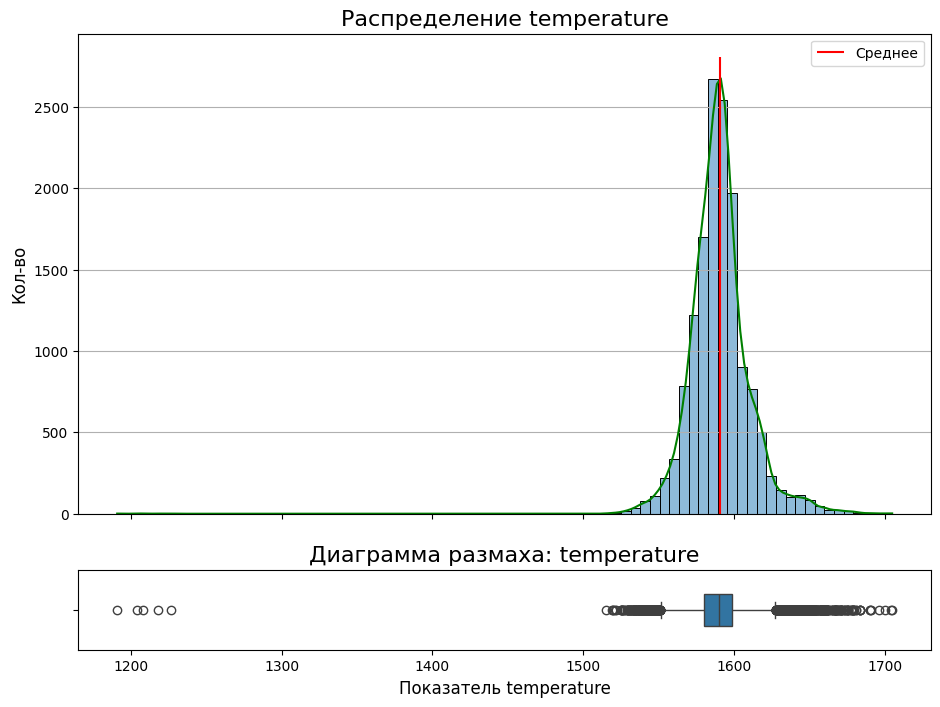

Описательные статистики:


count     mean    std     min     25%     50%     75%     max
temperature  14665.0  1590.72  20.39  1191.0  1580.0  1590.0  1599.0  1705.0

Значение моды: 1593.0


In [28]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(data_temp, 'temperature', 80)

Мы можем наблюдать аномальные значения по левую часть "уса": в технической документации для легированной стали диапазон температур начинается с 1320. Все, что ниже этого уровня, — процесс изготовления чугуна. Заказчик чугуном не занимается. Эти температуры считаются аномалиями и должны быть удалены, так как не соответствуют условиям изготовления стали. 

In [29]:
# Оставим в датасете только показатели температур, начиная с 1320
data_temp = data_temp.query('temperature >= 1320')

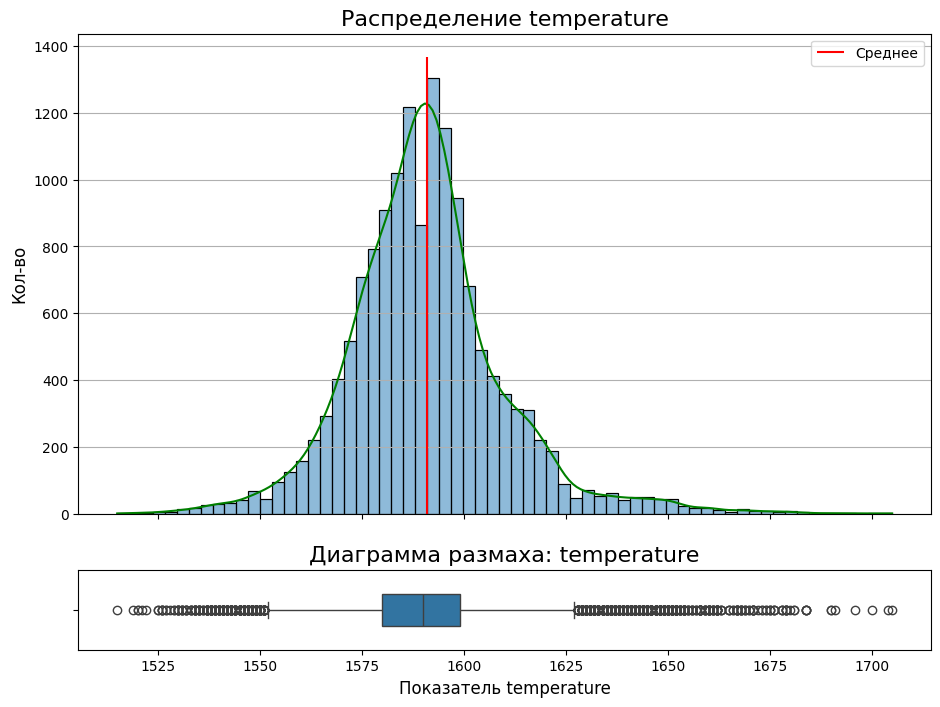

Описательные статистики:


count     mean    std     min     25%     50%     75%     max
temperature  14660.0  1590.85  19.14  1515.0  1580.0  1590.0  1599.0  1705.0

Значение моды: 1593.0


In [30]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(data_temp, 'temperature', 65)

Столбец`temperature` имеет распределение, приближенное к нормальному: среднее, медиана и мода практически совпадают и расположены в диапазоне от 1590 до 1593. Межквартильный размах температуры сплава расположен в диапазоне от 1580 до 1599. Средний показатель температуры составляет 1590. Также мы можем наблюдать наличие выбросов как по левую, так и по правую часть "усов", что может свидетельствовать о том, что температура сплава на разных итерациях обработки отличается. 

Рассмотрим столбец `time_measurement` — время замера температуры, в частности, взаимосвязь времени замера и номера партии. 

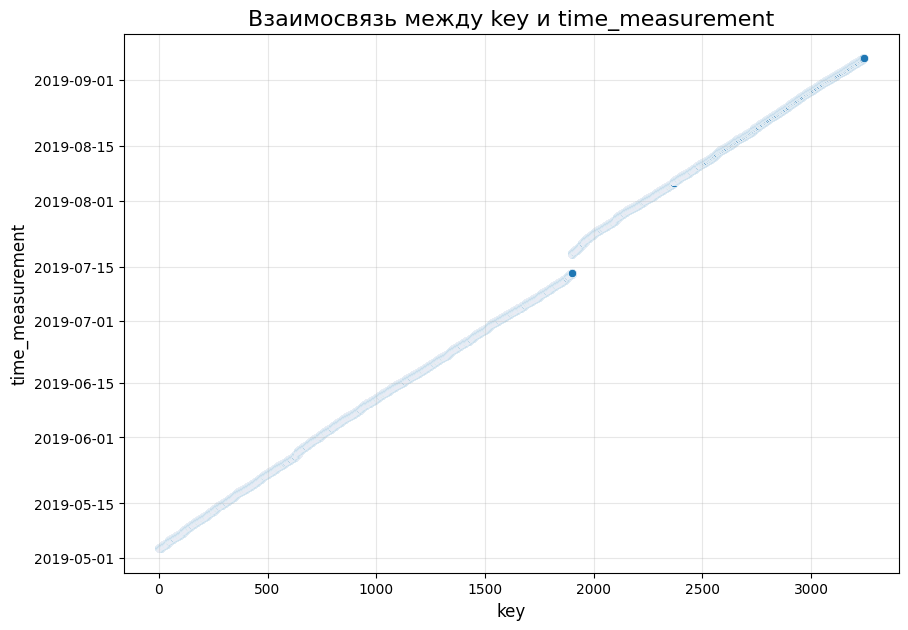

In [31]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(data_temp, 'key', 'time_measurement')

На графике мы видим прямую линейную зависимость между датой и временем замера температуры и партией: время замера каждой последующей партии проводилось позже предыдущей. У нас имеются данные с 3 мая по 6 сентября. Также мы можем наблюдать, что с 14 по 17 июля на заводе не проводили обработку стали.

### Проведем исследовательский анализ датасета `data_bulk` .

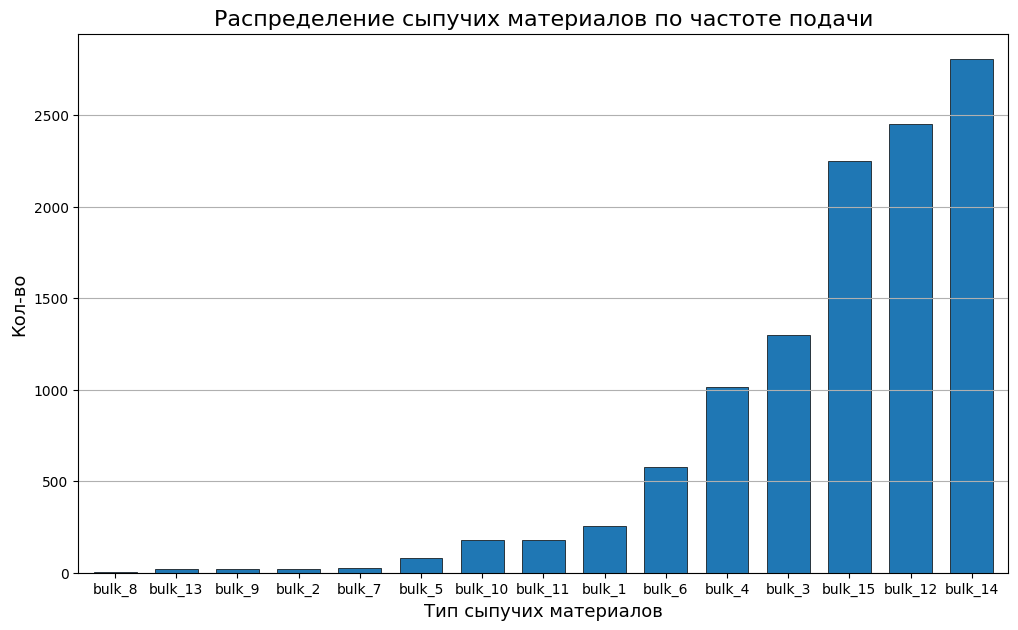

In [32]:
# Построим график распределения по частоте подачи сыпучих материалов
plt.figure(figsize=(12, 7))

# Построим график распределения по частоте подаче сыпучих материалов
data_bulk.loc[:, 'bulk_1':'bulk_15'].count().sort_values().plot(kind='bar', width=0.7, edgecolor='black', linewidth=0.5)
plt.xticks(rotation=0)
plt.title('Распределение сыпучих материалов по частоте подачи', fontsize=16)
plt.xlabel('Тип сыпучих материалов', fontsize=13)
plt.ylabel('Кол-во', fontsize=13)
plt.grid(True, axis='y')
plt.show()

Итак, на гарфике видно, что наиболее часто в сплавы добавляются сыпучие материалы типа `bulk_4`, `bulk_3`, `bulk_15`, `bulk_12` и `bulk_14`. Тогда как сыпучие материалы прочих типов добавляются довольно редко и в сосокупности применяются только в 16 % сплавов.

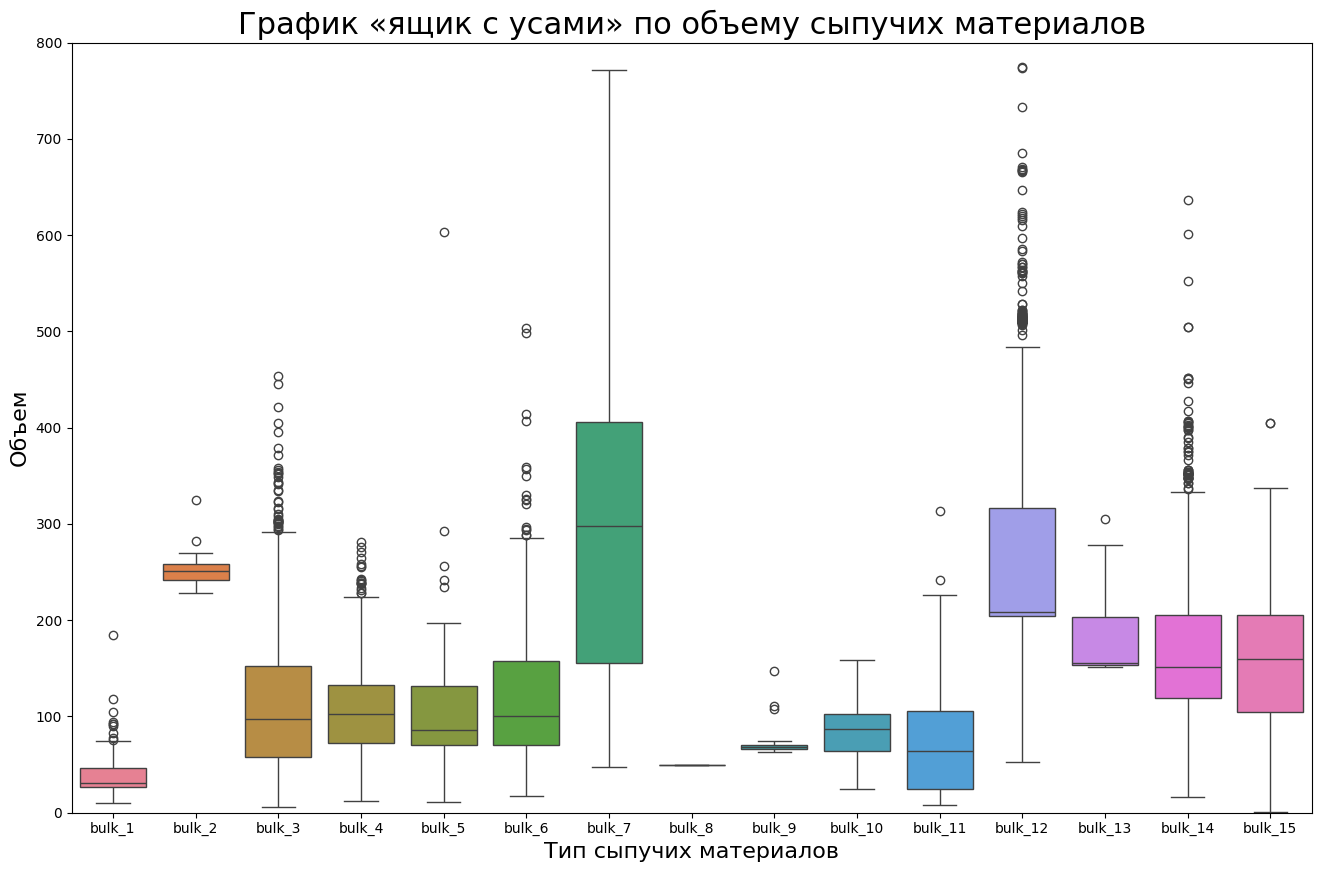

Описательные статистики:


bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  bulk_9  \
count   252.0    22.0  1298.0  1014.0    77.0   576.0    25.0     1.0    19.0   
mean     39.0   253.0   114.0   104.0   107.0   119.0   306.0    49.0    76.0   
std      18.0    21.0    75.0    48.0    82.0    72.0   191.0     NaN    22.0   
min      10.0   228.0     6.0    12.0    11.0    17.0    47.0    49.0    63.0   
25%      27.0   242.0    58.0    72.0    70.0    70.0   155.0    49.0    66.0   
50%      31.0   252.0    98.0   102.0    86.0   100.0   298.0    49.0    68.0   
75%      46.0   258.0   152.0   133.0   132.0   157.0   406.0    49.0    70.0   
max     185.0   325.0   454.0   281.0   603.0   503.0   772.0    49.0   147.0   

       bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
count    176.0    177.0   2450.0     18.0   2806.0   2248.0  
mean      83.0     77.0    260.0    181.0    170.0    161.0  
std       26.0     60.0    121.0     46.0     66.0     52.0  
min       24.0      8.0     53.0    151.0     16.0      1.0  
25%       64.0     25.0    204.0    153.0    119.0    105.0  
50%       86.0     64.0    208.0    156.0    151.0    160.0  
75%      102.0    106.0    316.0    204.0    206.0    205.0  
max      159.0    313.0   1849.0    305.0    636.0    405.0

In [33]:
# Построим график ящик с усами
plt.figure(figsize=(16, 10))
sns.boxplot(data=data_bulk.loc[:, 'bulk_1':'bulk_15'], flierprops={"marker": "o"})

plt.title('График «ящик с усами» по объему сыпучих материалов', fontsize=22)
plt.ylabel('Объем', fontsize=16)
plt.xlabel('Тип сыпучих материалов', fontsize=16)
plt.ylim(0, 800)
plt.show()

print('Описательные статистики:')
round(data_bulk.loc[:, 'bulk_1':'bulk_15'].describe(), 0)

Рассмотрим самые часто добавляемые сыпучие материалы:

Сыпучие материалы типа `bulk_4` подаются в 32 % сплавов. Средний объем подаваемого сыпучего материала данного типа составляет 104, межквартильный размах объема расположен в диапазоне от 72 до 133. Имеются выбросы по правую часть "уса", возможно, некоторые партии сплавов требуют большего объема сыпучего материала данного типа на определенных итерациях обработки.

Сыпучие материалы типа `bulk_3` подаются в 41 % сплавов. Средний объем подаваемого сыпучего материала данного типа составляет 114, межквартильный размах объема расположен в диапазоне от 58 до 152. Имеются выбросы по правую часть "уса", возможно, некоторые партии сплавов требуют большего объема сыпучего материала данного типа на определенных итерациях обработки.

Сыпучие материалы типа `bulk_15` подаются в 72 % сплавов. Средний объем подаваемого сыпучего материала данного типа составляет 161, межквартильный размах объема расположен в диапазоне от 105 до 205. Имеются выбросы по правую часть "уса", возможно, некоторые партии сплавов требуют большего объема сыпучего материала данного типа на определенных итерациях обработки.

Сыпучие материалы типа `bulk_12` подаются в 78 % сплавов. Средний объем подаваемого сыпучего материала данного типа составляет 260, межквартильный размах объема расположен в диапазоне от 204 до 316. Имеются выбросы по правую часть "уса", возможно, некоторые партии сплавов требуют большего объема сыпучего материала данного типа на определенных итерациях обработки.

Сыпучие материалы типа `bulk_14` подаются в 90 % сплавов. Средний объем подаваемого сыпучего материала данного типа составляет 170, межквартильный размах объема расположен в диапазоне от 119 до 206. Имеются выбросы по правую часть "уса", возможно, некоторые партии сплавов требуют большего объема сыпучего материала данного типа на определенных итерациях обработки.

Рассмотрим распределение самого распространенного сыпучего материала `bulk_14`.

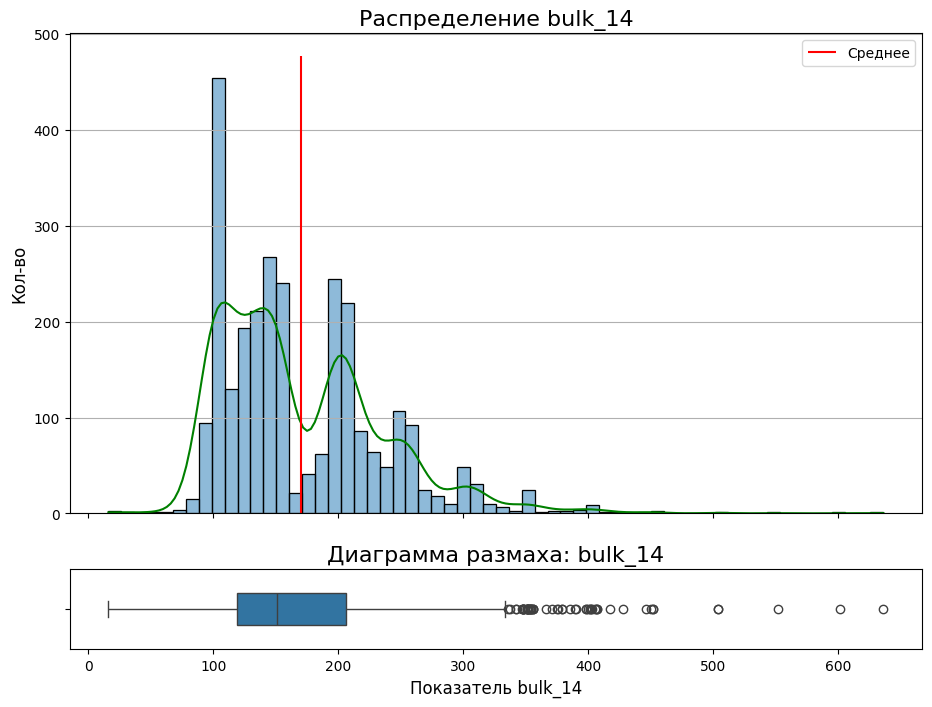

Описательные статистики:


count    mean    std   min    25%    50%     75%    max
bulk_14  2806.0  170.28  65.87  16.0  119.0  151.0  205.75  636.0

Значение моды: 102.0


In [34]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(data_bulk, 'bulk_14', 60)

Столбец `bulk_14` имеет распределение со смещением вправо. Межквартильный размах значения активной мощности расположен в диапазоне от 119 до 205. Среднее значение составляет 170. Имеются выбросы в правой части "уса", возможно, для некоторых партий сплавов требуется больший объем сыпучего материала `bulk_14`.

### Проведем исследовательский анализ датасета `data_bulk_time`.

Рассмотрим взаимосвязь времени добавления наиболее часто применяемого типа сыпучего материала `bulk_14` и номером партии.

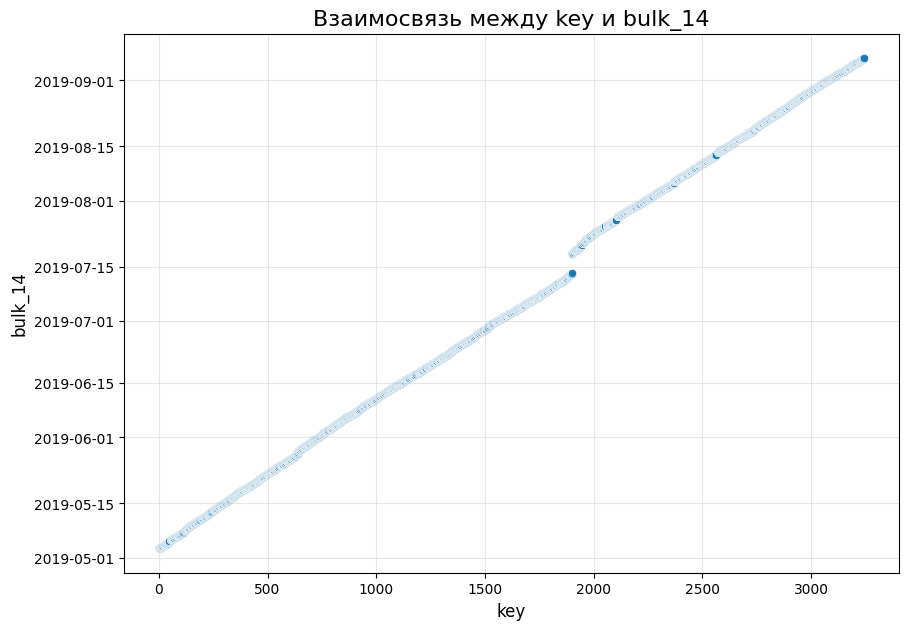

In [35]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(data_bulk_time, 'key', 'bulk_14')

Итак, мы видим аналогичную ситуацию, как и со столбцом `time_measurement` датасета **`data_temp`** — графики идентичны, значит, показатели дат и времени корректны. 

### Проведем исследовательский анализ датасета `data_wire`.

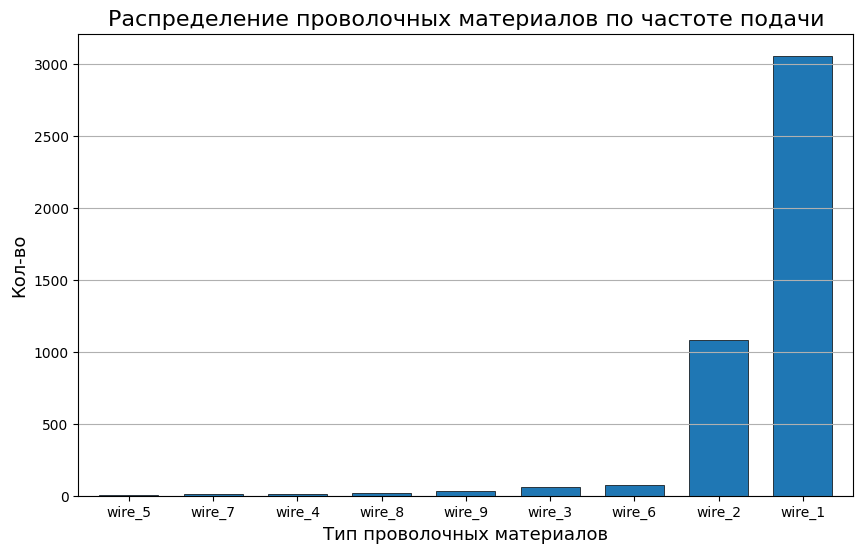

In [36]:
# Построим график распределения по частоте подачи сыпучих материалов
plt.figure(figsize=(10, 6))

# Построим график распределения по частоте подаче сыпучих материалов
data_wire.loc[:, 'wire_1':'wire_9'].count().sort_values().plot(kind='bar', width=0.7, edgecolor='black', linewidth=0.5)
plt.xticks(rotation=0)
plt.title('Распределение проволочных материалов по частоте подачи', fontsize=16)
plt.xlabel('Тип проволочных материалов', fontsize=13)
plt.ylabel('Кол-во', fontsize=13)
plt.grid(True, axis='y')
plt.show()

Итак, на графике мы можем отметить, что наиболее часто в сплавы добавляются проволочные материалы типа `wire_1` и `wire_2`. При этом тип `wire_1` добавляется в 99% всех сплавов, а тип `wire_2` — в 1/3 всех сплавов. Типы проволочных материалов с `wire_2` по `wire_9` добавляют крайне редко и в совокупности применяются только в 7% сплавов.

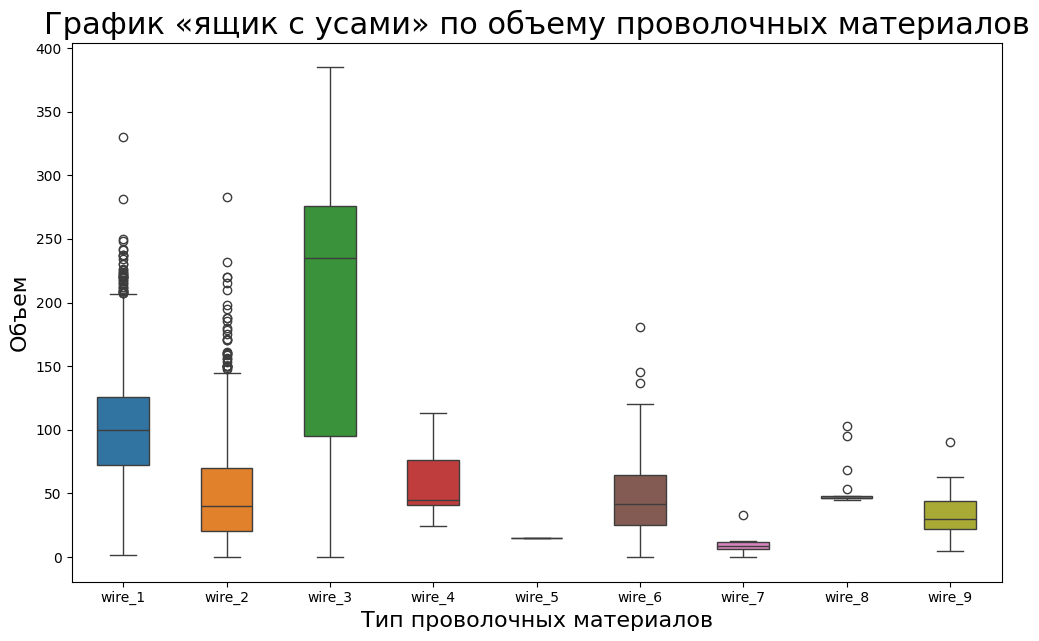

Описательные статистики:


wire_1  wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  wire_9
count  3055.0  1079.0    63.0    14.0     1.0    73.0    11.0    19.0    29.0
mean    101.0    51.0   189.0    57.0    15.0    48.0    10.0    54.0    34.0
std      42.0    39.0   100.0    29.0     NaN    34.0     9.0    17.0    20.0
min       2.0     0.0     0.0    24.0    15.0     0.0     0.0    45.0     5.0
25%      72.0    20.0    95.0    41.0    15.0    25.0     7.0    46.0    22.0
50%     100.0    40.0   235.0    45.0    15.0    42.0     9.0    46.0    30.0
75%     126.0    70.0   276.0    76.0    15.0    64.0    12.0    48.0    44.0
max     330.0   283.0   385.0   113.0    15.0   180.0    33.0   103.0    90.0

In [37]:
# Построим график ящик с усами
plt.figure(figsize=(12, 7))
sns.boxplot(data=data_wire.loc[:, 'wire_1':'wire_9'], flierprops={"marker": "o"}, width=0.5)

plt.title('График «ящик с усами» по объему проволочных материалов', fontsize=22)
plt.ylabel('Объем', fontsize=16)
plt.xlabel('Тип проволочных материалов', fontsize=16)
plt.show()

print('Описательные статистики:')
round(data_wire.loc[:, 'wire_1':'wire_9'].describe(), 0)

Рассмотрим самые часто добавляемые проволочные материалы:

Средний объем подаваемого проволочного материала типа `wire_1` составляет 100, межквартильный размах объема расположен в диапазоне от 72 до 125. Имеются выбросы по правую часть "уса", возможно, некоторые партии сплавов требуют большего объема проволочного материала данного типа на определенных итерациях обработки.

Средний объем подаваемого проволочного материала типа `wire_2` составляет 51, межквартильный размах объема расположен в диапазоне от 20 до 70. Имеются выбросы по правую часть "уса", возможно, некоторые партии сплавов требуют большего объема проволочного материала данного типа на определенных итерациях обработки. При этом можно отметить, что проволочного материала типа `wire_2` в среднем добавляют в два раза меньше, чем типа `wire_1`.

Рассмотрим распределение самого распространенного проволочного материала `wire_1`.

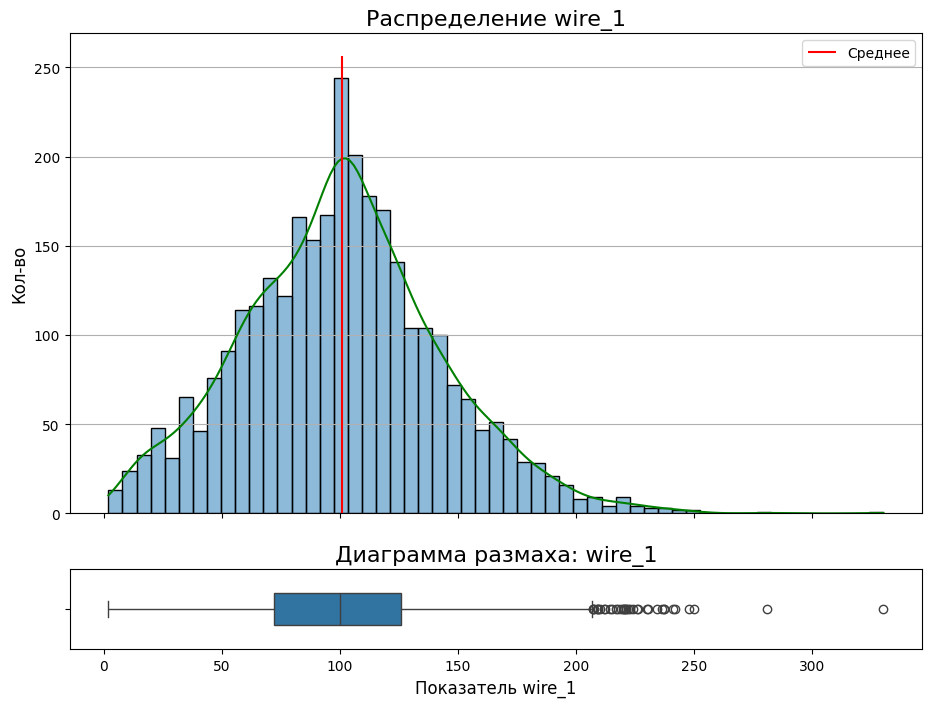

Описательные статистики:


count   mean    std   min    25%     50%     75%     max
wire_1  3055.0  100.9  42.01  1.92  72.12  100.16  126.06  330.31

Значение моды: 105.05


In [38]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(data_wire, 'wire_1', 55)

Столбец `bulk_14` имеет распределение со смещением вправо. Межквартильный размах значения активной мощности расположен в диапазоне от 72 до 126. Среднее значение составляет 100. Имеются выбросы в правой части "уса", возможно, для некоторых партий сплавов требуется больший объем проволочного материала `wire_1`.

### Проведем исследовательский анализ датасета `data_wire_time`. 

Рассмотрим взаимосвязь времени добавления наиболее часто применяемого типа проволочного материала `wire_1` и номером партии.

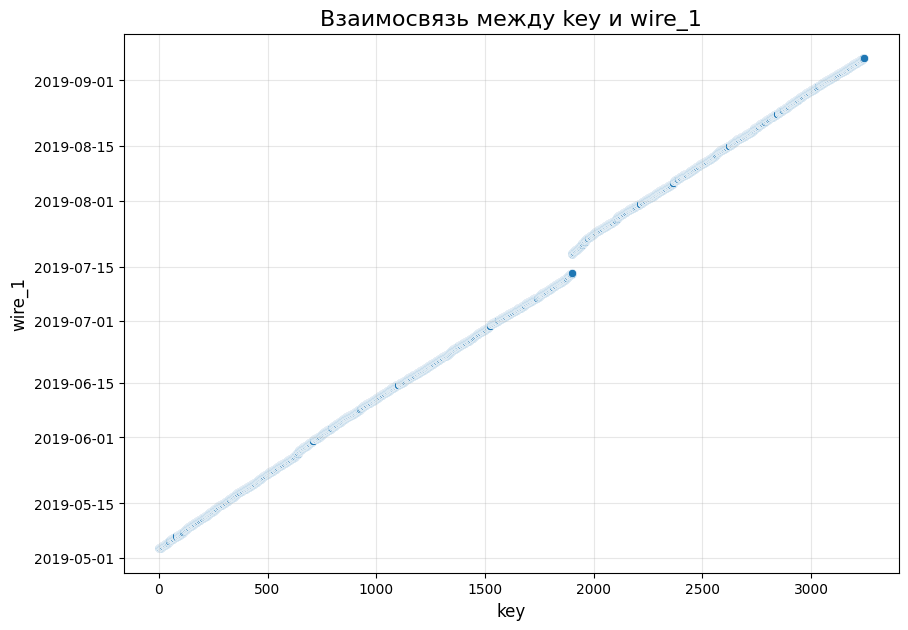

In [39]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(data_wire_time, 'key', 'wire_1')

Итак, мы видим аналогичную ситуацию, как и со столбцом `time_measurement` датасета **`data_temp`** — графики идентичны, значит, показатели дат и времени корректны. 

### Проведем исследовательский анализ датасета `data_arc`.

**Рассмотрим столбец `active_power`** — значение активной мощности.

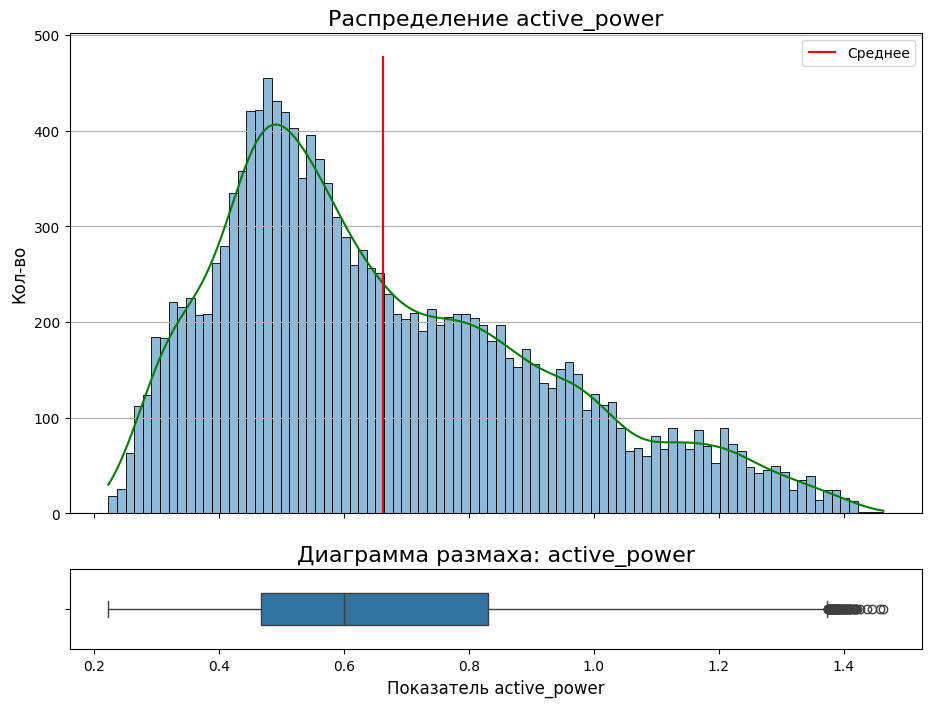

Описательные статистики:


count  mean   std   min   25%  50%   75%   max
active_power  14876.0  0.66  0.26  0.22  0.47  0.6  0.83  1.46

Значение моды: 0.51


In [40]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(data_arc, 'active_power', 90)

Столбец `active_power` (значение активной мощности) имеет распределение со смещением вправо и две моды. Межквартильный размах значения активной мощности расположен в диапазоне от 0.47 до 0.83. Среднее значение активной мощности составляет 0.66. Имеются выбросы в правой части "уса", возможно, некоторые партии сплавов имеют большие значения активной мощности при нагреве.

**Рассмотрим столбец `reactive_power`** — значение реактивной мощности.

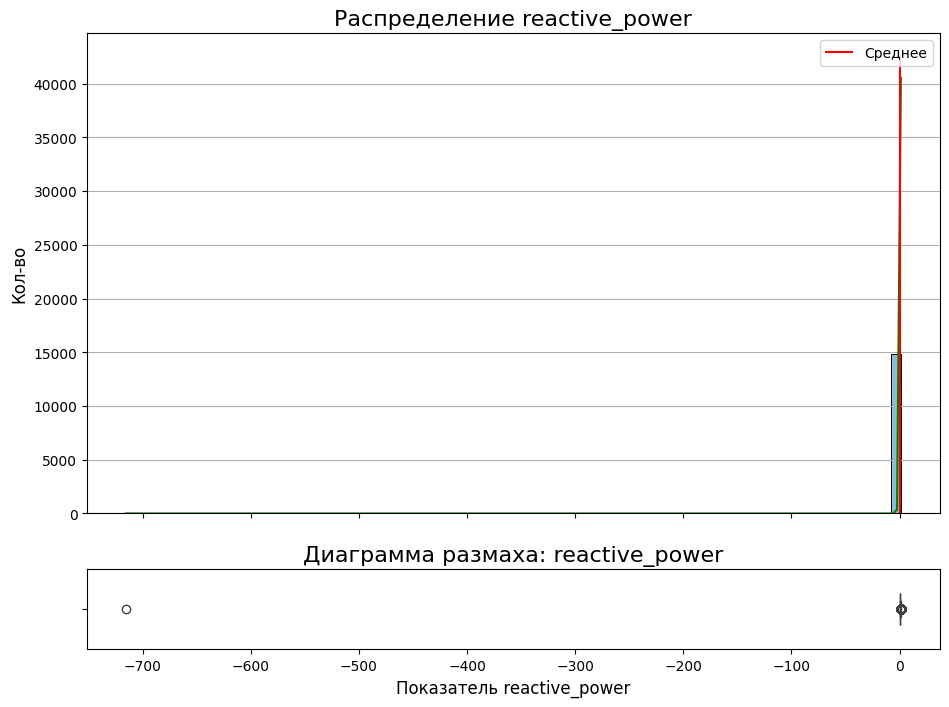

Описательные статистики:


count  mean   std     min   25%   50%   75%   max
reactive_power  14876.0  0.44  5.87 -715.48  0.34  0.44  0.61  1.27

Значение моды: 0.26


In [41]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(data_arc, 'reactive_power', 80)

In [42]:
# Выведем все отрицательные значения реактивной мощности
data_arc.query('reactive_power < 0')

key          begin_heat            end_heat  active_power  \
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   

      reactive_power  
9780     -715.479924

Итак, на диаграмме размаха и в полученном срезе мы видим одину анамалию — это отрицательное значение реактивной мощности -715.5. Нам следует удалить данную строку. 

In [43]:
# Удалим аномалию из датасета
data_arc = data_arc.query('reactive_power > 0')

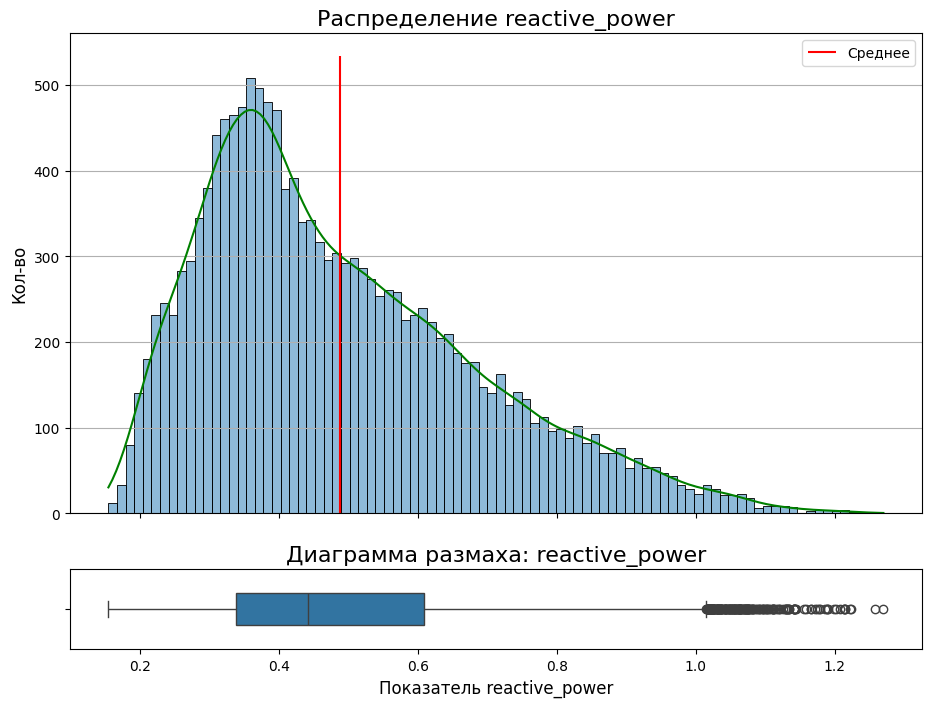

Описательные статистики:


count  mean  std   min   25%   50%   75%   max
reactive_power  14875.0  0.49  0.2  0.15  0.34  0.44  0.61  1.27

Значение моды: 0.26


In [44]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(data_arc, 'reactive_power', 90)

Столбец `reactive_power` (значение реактивной мощности) имеет распределение со смещением вправо и две моды. Межквартильный размах значения реактивной мощности расположен в диапазоне от 0.34 до 0.61. Среднее значение реактивной мощности составляет 0.49. Имеются выбросы в правой части "уса", возможно, некоторые партии сплавов имеют большие значения реактивной мощности при нагреве.

**Рассмотрим столбец `begin_heat`** — время начала нагрева, в частности, взаимосвязь времени начала нагрева и номера партии.

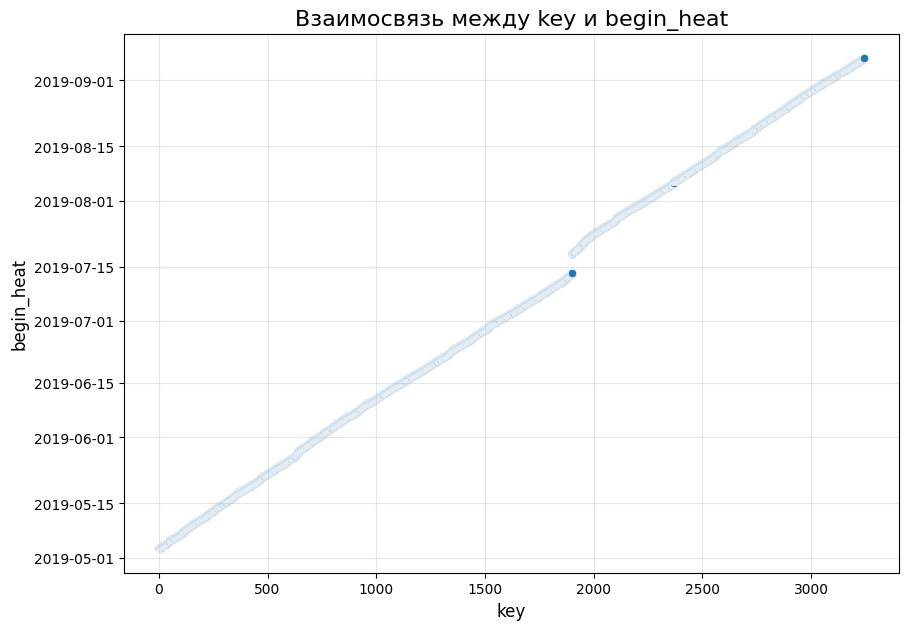

In [45]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(data_arc, 'key', 'begin_heat')

Итак, мы видим аналогичную ситуацию, как и со столбцом `time_measurement` датасета **`data_temp`** — графики идентичны, значит, показатели дат и времени корректны. 

**Рассмотрим столбец `end_heat`** — время окончания нагрева, в частности, взаимосвязь времени окончания нагрева и номера партии.

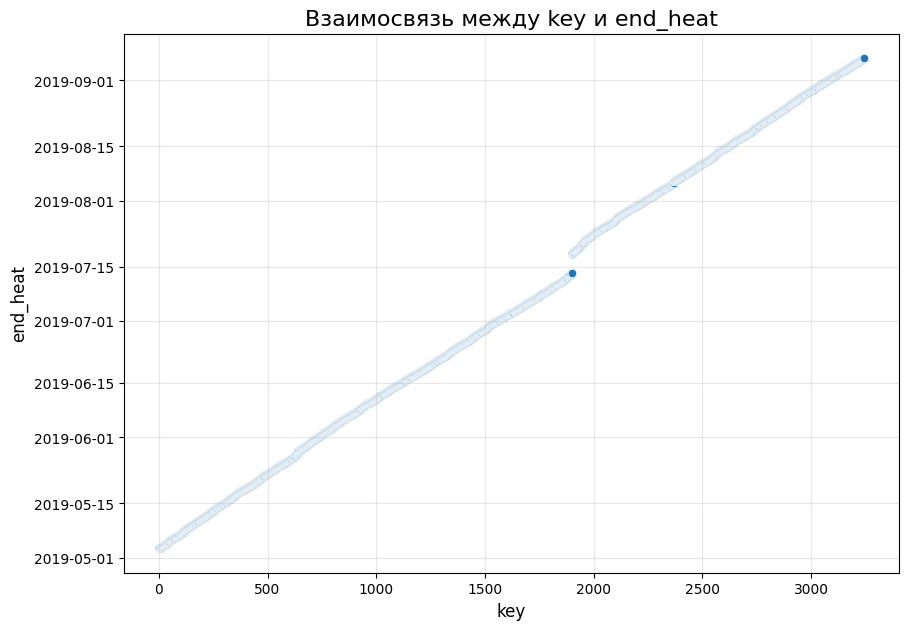

In [46]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(data_arc, 'key', 'end_heat')

Итак, мы видим аналогичную ситуацию, как и со столбцом `time_measurement` датасета **`data_temp`** — графики идентичны, значит, показатели дат и времени корректны. 

### Проведем исследовательский анализ датасета `data_gas`.

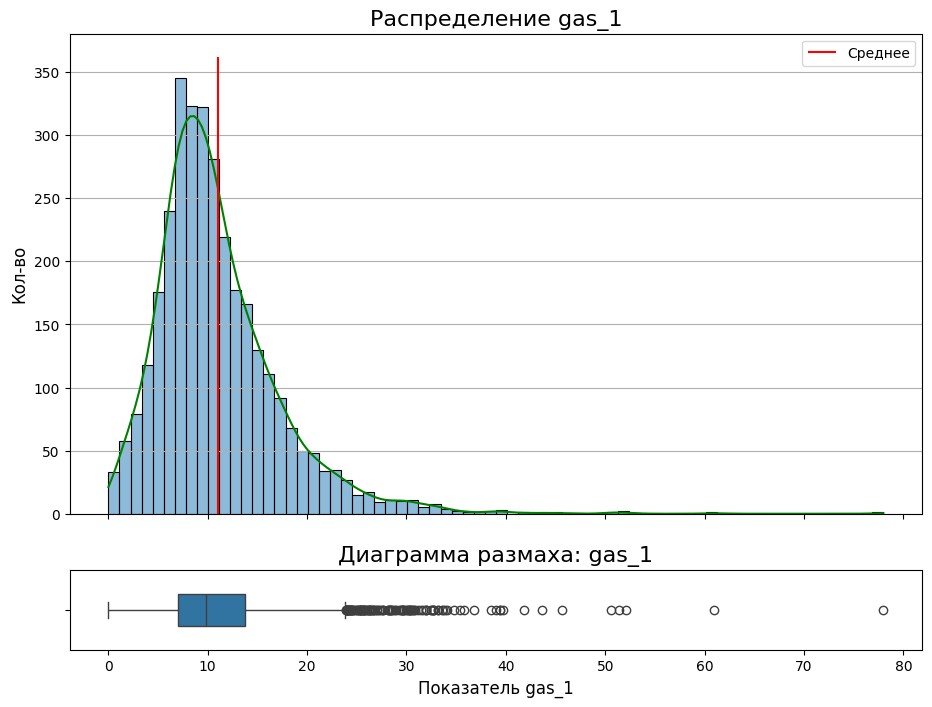

Описательные статистики:


count  mean   std   min   25%   50%    75%   max
gas_1  3239.0  11.0  6.22  0.01  7.04  9.84  13.77  78.0

Значение моды: 0.01


In [47]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(data_gas, 'gas_1', 70)

Столбец `gas_1` (объем подаваемого газа) имеет распределение со смещением вправо. Межквартильный размах объема подаваемого газа расположен в диапазоне от 7 до 14. Средний объем подаваемого газа равен 11. Имеются выбросы в правой части "уса", возможно, некоторые партии сплавов требуют большего объема газа на определенных итерациях обработки. 

### Промежуточный итог:

Мы провели исследовательский анализ датасетов и выяснили следующее:

 - Столбец `temperature` имеет нормальное распределение. Межквартильный размах температуры сплава расположен в диапазоне от 1580 до 1599. Средний показатель температуры составляет 1590. Удалены аномальные значения температур ниже 1320.
 
- Наиболее часто в сплавы добавляются сыпучие материалы типа `bulk_3`, `bulk_4`, `bulk_6`, `bulk_12`, `bulk_14` и `bulk_15`. Тогда как сыпучие материалы прочих типов добавляются довольно редко и в совокупности применяются только в 16 % сплавов.

     - сыпучие материалы типа `bulk_6` подаются в 18% сплавов, средний объем составляет 119;

     - сыпучие материалы типа `bulk_4` подаются в 32% сплавов, средний объем составляет 104;
       
     - сыпучие материалы типа `bulk_3` подаются в 41% сплавов, средний объем составляет 114;
      
     - сыпучие материалы типа `bulk_15` подаются в 72% сплавов, средний объем составляет 161;
      
     - сыпучие материалы типа `bulk_12` подаются в 78% сплавов, средний объем составляет 260;
      
     - сыпучие материалы типа `bulk_14` подаются в 90% сплавов, средний объем составляет 170.


- Наиболее часто в сплавы добавляются проволочные материалы типа `wire_1` и `wire_2`. При этом тип `wire_1` добавляется практически во все сплавы (в 99%), а тип `wire_2` — в 1/3 всех сплавов. Типы проволочных материалов с `wire_2` по `wire_9` добавляют крайне редко и в совокупности применяются только в 7% сплавов. 
     - средний объем подаваемого проволочного материала типа `wire_1` составляет 100; 
     - средний объем подаваемого проволочного материала типа `wire_2` составляет 51. 


- Столбец `active_power` (значение активной мощности) имеет распределение со смещением вправо. Среднее значение активной мощности составляет 0.66. Имеются выбросы с правой части "уса", возможно, некоторые партии сплавов имеют большие значения активной мощности при нагреве.


- Столбец `reactive_power` (значение реактивной мощности) имеет распределение со смещением вправо. Среднее значение реактивной мощности составляет 0.49. Удалили аномальное значение — отрицательное значение реактивной мощности. 


- Столбец `gas_1` (объем подаваемого газа) имеет распределение со смещением вправо. Межквартильный размах объема подаваемого газа расположен в диапазоне от 7 до 14. Средний объем подаваемого газа равен 11. Каждой партии подается индивидуальный объем газа.

## Отбор входящих признаков и объединение выбранных признаков в один датафрейм.

### Рассмотрим признаки датасета `data_temp`.

По условию заказчика, хорошие партии имеют два и более замеров температур. Очистим датасет `data_temp` от некачественных партий, а также удалим итерации, которые не содержат показатели температуры (ранее мы выяснили, что столбец `temperature` содержит 3427 пропущенных значений)

In [48]:
# Удалим пропуски (пропуски содержит только столбец temperature)
data_temp = data_temp.dropna()

print(f'Кол-во пропущенных значений в столбце temperature: {data_temp["temperature"].isna().sum()}')

Кол-во пропущенных значений в столбце temperature: 0


In [49]:
# Оставим в датасете партии с двумя и более замерами температур
data_temp = data_temp[data_temp['key'].duplicated(keep=False)]

In [50]:
# Проверим, остались ли в датасете некачественные партии
data_temp.groupby('key').filter(lambda x: len(x) < 2)

Empty DataFrame
Columns: [key, time_measurement, temperature]
Index: []

Итак, мы успешно очистили дадатес `data_temp` от пропущенных значений в столбце `temperature` и от некачественных партий. 

In [51]:
# Выведем данные температур первых двух партий для сверки
data_temp.head(12)

key    time_measurement  temperature
0     1 2019-05-03 11:02:04       1571.0
1     1 2019-05-03 11:07:18       1604.0
2     1 2019-05-03 11:11:34       1618.0
3     1 2019-05-03 11:18:04       1601.0
4     1 2019-05-03 11:25:59       1606.0
5     1 2019-05-03 11:30:38       1613.0
6     2 2019-05-03 11:34:04       1581.0
7     2 2019-05-03 11:38:40       1577.0
8     2 2019-05-03 11:46:09       1589.0
9     2 2019-05-03 11:49:38       1604.0
10    2 2019-05-03 11:55:09       1602.0
11    3 2019-05-03 12:06:44       1596.0

Сохраним **целевой признак** — последнюю температуру сплава партии в отдельный датасет, а первый показатель замера температуры будем использовать как входящий признак, промежуточные же показатели температур для обучения модели использовать мы не будем. 

In [52]:
# Сохраним целевой признак (последние показатели температуры партии) в датасет target
target = data_temp.drop_duplicates(subset = 'key', keep='last')

# Выведем первые пять строк
target.head()

key    time_measurement  temperature
5     1 2019-05-03 11:30:38       1613.0
10    2 2019-05-03 11:55:09       1602.0
16    3 2019-05-03 12:35:57       1599.0
21    4 2019-05-03 12:59:47       1625.0
26    5 2019-05-03 13:36:39       1602.0

Итак, целевой признак выделен корректно: показатели последних температур партии 1 и 2 исходного дадасета `data_temp` соответствуют показателям температур нового датасета `target`. Удалим столбец `time_measurement`, так как для обучения он нам не потребуется и переименуем столбец `temperature` в `target_temp`.

In [53]:
# Удалим столбец time_measurement
target = target.drop('time_measurement', axis=1)

# Переименуем столбец temperature в target_temp
target = target.rename(columns={'temperature': 'target_temp'})

# Выведем первые пять строк
target.head()

key  target_temp
5     1       1613.0
10    2       1602.0
16    3       1599.0
21    4       1625.0
26    5       1602.0

Столбец `time_measurement` успешно удален, а столбец `temperature` преименован в `target_temp`.

In [54]:
# Сохраним входящий признак (первые показатели температуры партии) в датасет target
data_temp = data_temp.drop_duplicates(subset = 'key', keep='first')

# Выведем первые пять строк
data_temp.head()

key    time_measurement  temperature
0     1 2019-05-03 11:02:04       1571.0
6     2 2019-05-03 11:34:04       1581.0
11    3 2019-05-03 12:06:44       1596.0
17    4 2019-05-03 12:39:27       1601.0
22    5 2019-05-03 13:11:03       1576.0

Итак, входящий признак выделен корректно: показатели первых температур партии 1 и 2 исходного дадасета `data_temp` соответствуют показателям температур обновленного датасета `data_temp`. Удалим столбец `time_measurement`, так как для обучения он нам не потребуется.

In [55]:
# Удалим столбец time_measurement
data_temp = data_temp.drop('time_measurement', axis=1)

# Выведем первые пять строк
data_temp.head()

key  temperature
0     1       1571.0
6     2       1581.0
11    3       1596.0
17    4       1601.0
22    5       1576.0

Столбец `time_measurement` успешно удален.

### Рассмотрим признаки датасета `data_arc`.

Добавим столбец со временем нагрева `time_heat`, рассчитав разность между временем окончания нагрева и начала нагрева. Сами столбцы с датой и временем начала нагрева `begin_heat` и окончания нагрева `end_heat` для обучения использовать не будем, поэтому удалим их из датасета. 

Для каждой партии посчитаем среднее значение активной `active_power` и реактивной мощности `reactive_power`. Также  добавим новый признак: среднее значение полной мощности `full_mean_power` для каждой партии. 
Формула полной мощности, равной геометрической сумме активной и реактивной мощности: S = √(P² + Q²). Здесь S — полная мощность, P —  `active_power` (активная мощность), Q — `reactive_power` (реактивная мощность). 

In [56]:
# Добавим столбец со временем нагрева `time_heat`
data_arc['time_heat'] = (data_arc['end_heat'] - data_arc['begin_heat']).dt.total_seconds()

In [57]:
# Выведем первые пять строк
data_arc.head()

key          begin_heat            end_heat  active_power  reactive_power  \
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253   
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438   
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460   
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979   
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691   

   time_heat  
0      228.0  
1      185.0  
2      172.0  
3      365.0  
4      148.0

Столбец `time_heat` — полная время нагрева добавлен корректно. 

In [58]:
# Удалим столбцы begin_heat и end_heat
data_arc = data_arc.drop(['begin_heat', 'end_heat'], axis=1)

In [59]:
# Добавим столбец full_power - значение полной мощности на каждой итерации
data_arc['full_power'] = np.sqrt(np.square(data_arc['active_power']) + np.square(data_arc['reactive_power']))

In [60]:
# Выведем первые пять строк
data_arc.head()

key  active_power  reactive_power  time_heat  full_power
0    1      0.305130        0.211253      228.0    0.371123
1    1      0.765658        0.477438      185.0    0.902319
2    1      0.580313        0.430460      172.0    0.722536
3    1      0.518496        0.379979      365.0    0.642824
4    1      0.867133        0.643691      148.0    1.079934

Столбец `full_power` — полная мощность добавлен корректно. Теперь посчитаем сумму значений активной `active_power`, реактивной мощности `reactive_power`, полной мощности `full_power` и времени нагрева `time_heat` по каждой каждой партии.

In [61]:
# Посчитаем сумму значений активной, реактивной, полной мощностей и времени нагрева для каждой партии
data_arc = data_arc.groupby('key')[[
    'active_power', 'reactive_power', 'full_power', 'time_heat']].sum().reset_index()

# Переименуем столбцы
data_arc = data_arc.rename(columns=
                           {
                               'active_power':'sum_active_power', 
                               'reactive_power': 'sum_reactive_power',
                               'full_power': 'sum_full_power',
                               'time_heat': 'sum_time_heat'
                           }
                          )
# Выведем первые пять строк
data_arc.head() 

key  sum_active_power  sum_reactive_power  sum_full_power  sum_time_heat
0    1          3.036730            2.142821        3.718736         1098.0
1    2          2.139408            1.453357        2.588349          811.0
2    3          4.063641            2.937457        5.019223          655.0
3    4          2.706489            2.056992        3.400038          741.0
4    5          2.252950            1.687991        2.816980          869.0

Итак, мы успешно удалили столбцы `begin_heat` и `end_heat` и добавили столбцы:
- `sum_active_power` — сумма активных мощностей для каждой партии;
- `sum_reactive_power` — сумма реактивных мощностей для каждой партии;
- `sum_full_power` — сумма полных мощностей для каждой партии;
- `sum_time_heat` — сумма времени нагрева для каждой партии.

### Рассмотрим признаки датасета `data_bulk`.

Ранее мы обнаружили, что пропуски в столбцах с `bulk_1` по `bulk_15` означают, что в различные партии добавляют определенный тип сыпучих материалов. Значит, пропущенные значения `NaN` мы можем заполнить `0`. 

Для обучения модели оставим только наиболее часто добавляемые в сплавы сыпучие материалы: `bulk_3`, `bulk_4`, `bulk_6`, `bulk_12` и `bulk_14`, `bulk_15`.

In [62]:
# Сохраним нужные сыпучие материалы и пропуски заполним нулями
data_bulk = data_bulk[
    [
        'key', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15'
    ]].fillna(0)

# Выведем информацию о датасете
display(data_bulk.head())
print('Кол-во пропусков:')
print(data_bulk.isna().sum())

key  bulk_3  bulk_4  bulk_6  bulk_12  bulk_14  bulk_15
0    1     0.0    43.0     0.0    206.0    150.0    154.0
1    2     0.0    73.0     0.0    206.0    149.0    154.0
2    3     0.0    34.0     0.0    205.0    152.0    153.0
3    4     0.0    81.0     0.0    207.0    153.0    154.0
4    5     0.0    78.0     0.0    203.0    151.0    152.0

Кол-во пропусков:
key        0
bulk_3     0
bulk_4     0
bulk_6     0
bulk_12    0
bulk_14    0
bulk_15    0
dtype: int64


Мы успешно сохранили столбцы с самыми распространенными типами сыпучих материалов, а также заполнили все пропуски нулями. 

### Рассмотрим признаки датасета `data_wire`.

Пропуски в столбцах с `wire_1` по `wire_9` означают, что в различные партии добавляют определенный тип проволочных материалов. Значит, пропущенные значения `NaN` мы можем заполнить `0`. 

Для обучения модели оставим только наиболее часто добавляемые в сплавы проволочные материалы: `wire_1`, и `wire_2`.

In [63]:
# Сохраним нужные проволочные материалы и пропуски заполним нулями
data_wire = data_wire[['key', 'wire_1', 'wire_2']].fillna(0)
# Выведем информацию о датасете
display(data_wire.head())
print('Кол-во пропусков:')
print(data_wire.isna().sum())

key     wire_1   wire_2
0    1  60.059998  0.00000
1    2  96.052315  0.00000
2    3  91.160157  0.00000
3    4  89.063515  0.00000
4    5  89.238236  9.11456

Кол-во пропусков:
key       0
wire_1    0
wire_2    0
dtype: int64


Мы успешно сохранили столбцы с самыми распространенными типами проволочных материалов, а также заполнили все пропуски нулями. 

Данные с датой и временем с датасетов `data_bulk_time` и `data_wire_time` для обучения моделей мы использовать не будем, так как у нас задача регрессии. Данные датасета `data_gas` обрабатывать нет необходимости, так как каждая партия содержит только один показатель объема подаваемого газа. 

Объединим отобранные признаки из обработанных датасетов `target`, `data_temp`, `data_arc`, `data_bulk`, `data_wire` и `data_gas`  в один датасет **`df_total`**. По условию заказчика важно, чтобы объединение таблиц было по ключам, которые есть во всех таблицах, значит, объединение будем производить по столбцу `key` использовать параметр `inner`.

In [64]:
# Создадим список датасетов для слияния
datasets = [data_temp, data_arc, data_bulk, data_wire, data_gas]

In [65]:
# Сохраним в датасет df_total превый датасет target
df_total = target

# Циклом присоединим остальные датасеты
for data in datasets:
    df_total = df_total.merge(data, on='key', how='inner')

In [66]:
# Проверим наличие дубликатов по столбцу 'key'
f'Кол-во дубликатов по столбцу key: {df_total["key"].duplicated().sum()}'

'Кол-во дубликатов по столбцу key: 0'

In [67]:
# Сделаем столбец 'key' индексным
df_total = df_total.set_index('key')

In [68]:
# Применим к датасету собственную функцию df_info()
df_info(df_total)

<class 'pandas.core.frame.DataFrame'>
Index: 2329 entries, 1 to 2499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   target_temp         2329 non-null   float64
 1   temperature         2329 non-null   float64
 2   sum_active_power    2329 non-null   float64
 3   sum_reactive_power  2329 non-null   float64
 4   sum_full_power      2329 non-null   float64
 5   sum_time_heat       2329 non-null   float64
 6   bulk_3              2329 non-null   float64
 7   bulk_4              2329 non-null   float64
 8   bulk_6              2329 non-null   float64
 9   bulk_12             2329 non-null   float64
 10  bulk_14             2329 non-null   float64
 11  bulk_15             2329 non-null   float64
 12  wire_1              2329 non-null   float64
 13  wire_2              2329 non-null   float64
 14  gas_1               2329 non-null   float64
dtypes: float64(15)
memory usage: 291.1 KB


Empty DataFrame
Columns: [target_temp, temperature, sum_active_power, sum_reactive_power, sum_full_power, sum_time_heat, bulk_3, bulk_4, bulk_6, bulk_12, bulk_14, bulk_15, wire_1, wire_2, gas_1]
Index: []

target_temp  temperature  sum_active_power  sum_reactive_power  \
key                                                                   
1         1613.0       1571.0          3.036730            2.142821   
2         1602.0       1581.0          2.139408            1.453357   
3         1599.0       1596.0          4.063641            2.937457   
4         1625.0       1601.0          2.706489            2.056992   
5         1602.0       1576.0          2.252950            1.687991   

     sum_full_power  sum_time_heat  bulk_3  bulk_4  bulk_6  bulk_12  bulk_14  \
key                                                                            
1          3.718736         1098.0     0.0    43.0     0.0    206.0    150.0   
2          2.588349          811.0     0.0    73.0     0.0    206.0    149.0   
3          5.019223          655.0     0.0    34.0     0.0    205.0    152.0   
4          3.400038          741.0     0.0    81.0     0.0    207.0    153.0   
5          2.816980          869.0     0.0    78.0     0.0    203.0    151.0   

     bulk_15     wire_1   wire_2      gas_1  
key                                          
1      154.0  60.059998  0.00000  29.749986  
2      154.0  96.052315  0.00000  12.555561  
3      153.0  91.160157  0.00000  28.554793  
4      154.0  89.063515  0.00000  18.841219  
5      152.0  89.238236  9.11456   5.413692

(None, None)

В общем датасете `df_total` отсутствуют пропуски и дубликаты, значит, объединение произошло корректно. В итоге у нас получился датасет с 2329 строками (т.е. содержит данные о 2329 партиях сплавов). Столбец `'key` стал индексным, что поможет нам не использовать данный признак при обучении, но мы сможем обратиться к нему через `.index` при необходимости. Столбец `target_temp` — это **целевой признак**, который необходимо будет предсказать. 

### Промежуточный итог:

Мы провели следующую предобработку датасетов:

- Из датасета `data_temp` выделили два датасета:
     - датасет `target`, в котором оставили последнюю температуру сплава партии из столбца `temperature` исходного датасета и столбец `key`, с соответствующим номером партии;
     - обновлили исходных датасет `data_temp`, в котором оставили первую температуру сплава партии из столбца `temperature` исходного датасета и столбец `key`, с соответствующим номером партии.


- Из дадасета `data_arc`:
     - удалали столбцы с датой и временем начала нагрева `begin_heat` и окончания нагрева `end_heat`;
     - рассчитали значение полной мощности `full_power` и время нагрева `time_heat` для каждой партии;
     - рассчитали сумму значениий активной `sum_active_power`, реактивной `sum_reactive_power` и полной `sum_full_power` мощностей, а также суммарное время нагрева `sum_time_heat` для каждой партии. 

- В датасете `data_bulk`:
     - оставили только наиболее часто добавляемые в сплавы сыпучие материалы: столбцы `bulk_3`, `bulk_4`, `bulk_6`, `bulk_12`, `bulk_14` и `bulk_15`.
     
     
- В датасете `data_wire`:
     - оставили только наиболее часто добавляемые в сплавы проволочные материалы: столбцы `wire_1` и `wire_2`.
 
 
 
 
 
Создали один общий датасет `df_total` для обучения модели, в который вошли следующие данные:

- `key` — номер партии сделали индексным столбцом;
- **`target_temp`** — **целевой признак**, показатель последней температуры сплава партии;
- `temperature`	— показатель первой температуры сплава партии;
- `sum_active_power` — сумма значений активных мощностей для каждой партии;
- `sum_reactive_power` — сумма значений реактивных мощностей для каждой партии;
- `sum_full_power` — сумма значений полных мощностей для каждой партии;
- `sum_time_heat` — суммарное время нагрева для каждой партии;
- `bulk_3` — объем подаваемого сыпучего материала для каждой партии;	 
- `bulk_4` — объем подаваемого сыпучего метериала для каждой партии;		
- `bulk_6` — объем подаваемого сыпучего метериала для каждой партии;	
- `bulk_12` — объем подаваемого сыпучего метериала для каждой партии;		
- `bulk_14` — объем подаваемого сыпучего метериала для каждой партии;		
- `bulk_15` — объем подаваемого сыпучего метериала для каждой партии;
- `wire_1` — объем подаваемого проволочного материала для каждой партии;	
- `wire_2` — объем подаваемого проволочного материала для каждой партии;	
- `gas_1` — объём подаваемого газа для каждой партии.

## Исследовательский анализ объединённого датасета `df_total`.

### Рассмотрим целевой признак `target_temp` — показатель последней температуры сплава партии.

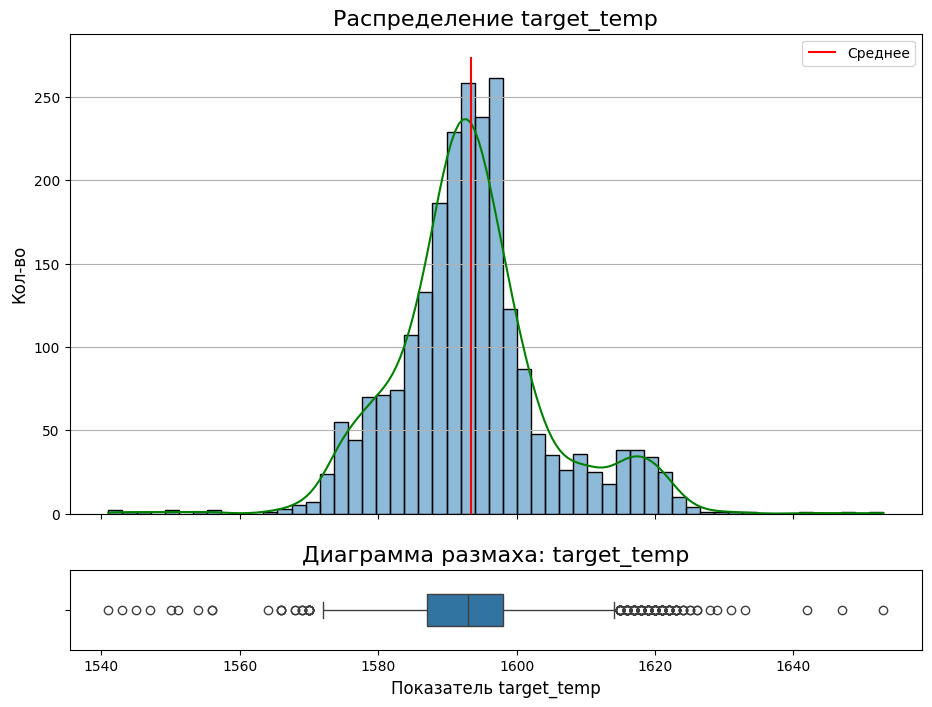

Описательные статистики:


count     mean   std     min     25%     50%     75%     max
target_temp  2329.0  1593.37  11.2  1541.0  1587.0  1593.0  1598.0  1653.0

Значение моды: 1593.0


In [69]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'target_temp', 55)

Целевой признак `target_temp` имеет нормальное распределение: среднее, медиана и мода совпадают и составляют 1593. Межквартильный размах температуры сплава расположен в диапазоне от 1587 до 1598. Средний показатель температуры составляет 1593. Также мы можем наблюдать наличие выбросов как по левую, так и по правую часть "ящика с усами", что может свидетельствовать о том, что температура сплава на разных итерациях обработки отличается; однако количество и размер выбросов сократились в сравнении с изначальным распределением столбца `temperature` датасета `data_temp`. 

### Рассмотрим  признак `temperature`	— показатель первой температуры сплава партии.

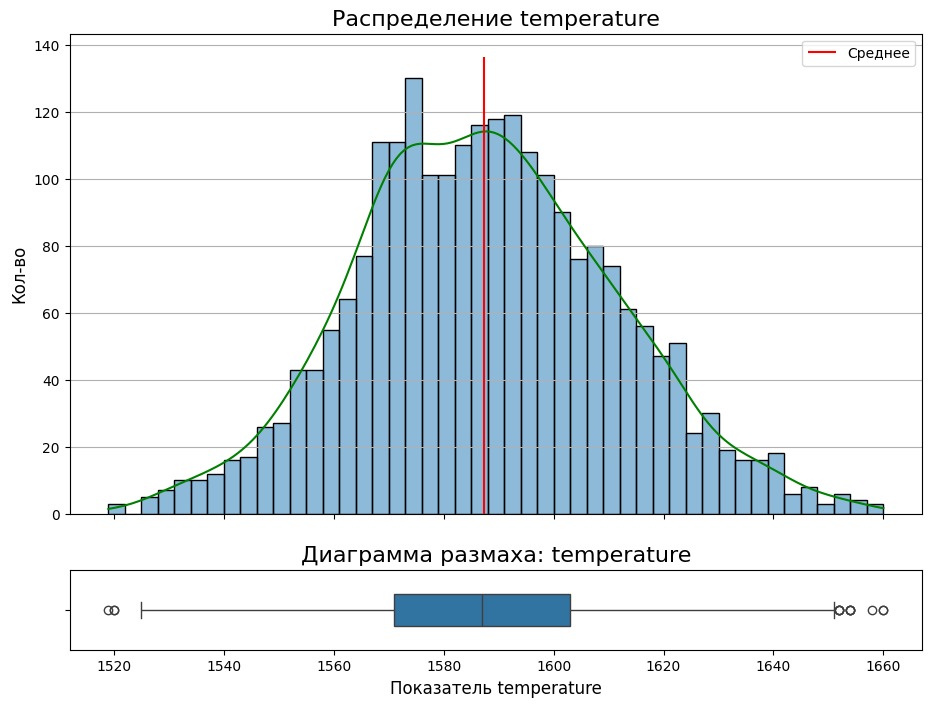

Описательные статистики:


count     mean    std     min     25%     50%     75%     max
temperature  2329.0  1587.39  23.62  1519.0  1571.0  1587.0  1603.0  1660.0

Значение моды: 1588.0


In [70]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'temperature', 47)

Признак `temperature` имеет нормальное распределение: среднее, медиана и мода практически совпадают. Межквартильный размах температуры сплава расположен в диапазоне от 1519 до 1603. Средний показатель температуры составляет 1588. Также мы можем наблюдать наличие выбросов как по левую, так и по правую часть "ящика с усами"; однако количество и размер выбросов сократились в сравнении с изначальным распределением столбца `temperature` датасета `data_temp`. 

Средний показатель первой температуры на 5 ниже среднего показателя последней температуры сплава (средний показатель 1588 у первого замера и 1593 у последнего).

Рассмотрим взаимосвязь признака `temperature` с **целевым признаком `target_temp`**.

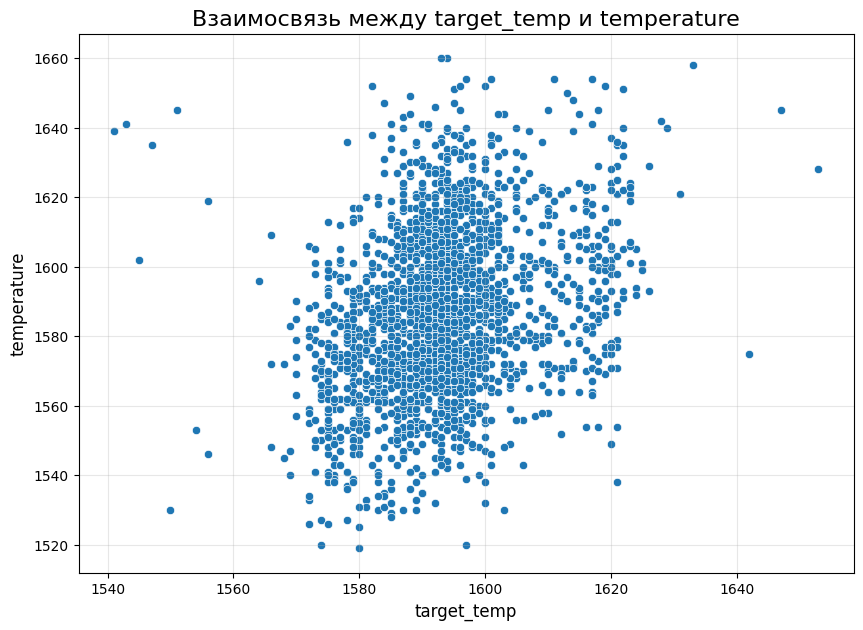

In [71]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'temperature')

На графике линейная зависимость между входящим признаком `temperature` и целевым признаком `target_temp` отсутствует. Нелинейная зависимость также не наблюдается.

### Рассмотрим  признак `sum_active_power` — суммарная активная мощность для каждой партии.

Рассмотрим распределение признака `sum_active_power`.

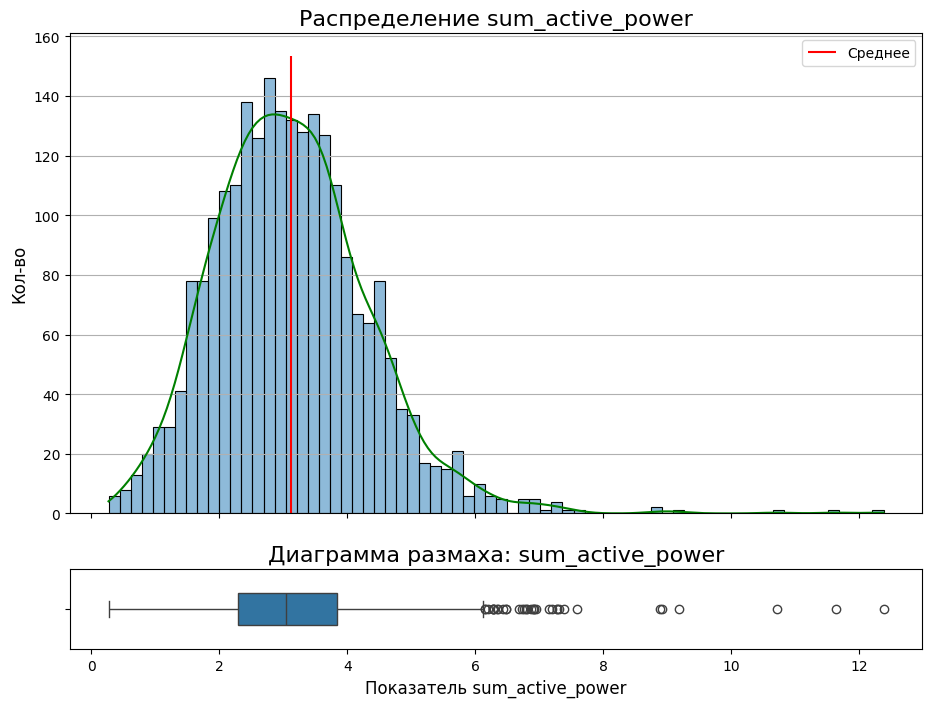

Описательные статистики:


count  mean   std   min   25%   50%   75%    max
sum_active_power  2329.0  3.13  1.22  0.27  2.29  3.04  3.83  12.38

Значение моды: 0.27


In [72]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'sum_active_power', 70)

Признак `sum_active_power` (суммарная активная мощность) имеет распределение со смещением вправо. Межквартильный размах суммарной активной мощности расположен в диапазоне от 0.58 до 0.74. Среднее значение активной мощности составляет 0.66. Имеются незначительное количество выбросов в левой части "уса" и большее их количество по правую часть "уса".

Рассмотрим взаимосвязь признака `sum_active_power` с **целевым признаком `target_temp`**.

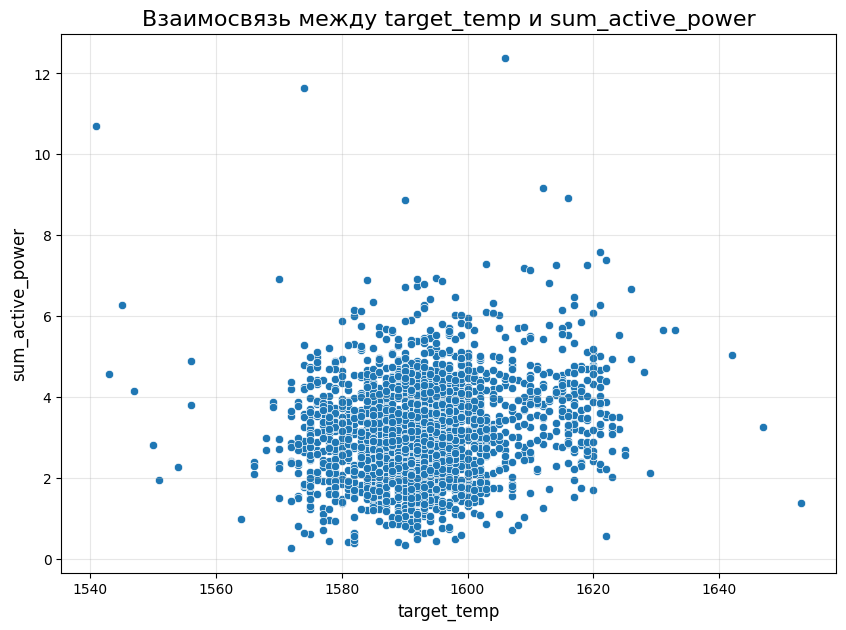

In [73]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'sum_active_power')

На графике линейная зависимость между входящим признаком `sum_active_power` и целевым признаком `target_temp` отсутствует. Нелинейная зависимость также не наблюдается.

### Рассмотрим  признак `sum_reactive_power` — суммарная реактивная мощность для каждой партии.

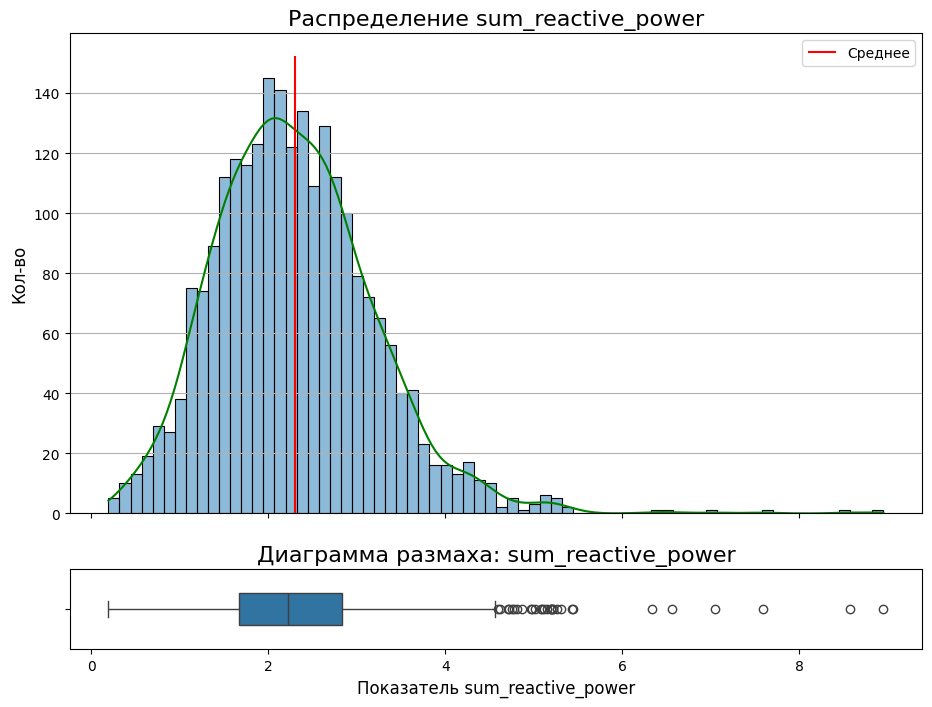

Описательные статистики:


count  mean  std  min   25%   50%   75%   max
sum_reactive_power  2329.0   2.3  0.9  0.2  1.67  2.23  2.83  8.95

Значение моды: 1.08


In [74]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'sum_reactive_power', 70)

Признак `sum_reactive_power` (суммарная реактивная мощность) имеет распределение со смещением вправо. Межквартильный размах суммарной реактивной мощности расположен в диапазоне от 1.67 до 2.83. Среднее значение суммарной реактивной мощности составляет 2.3. Имеется незначительное количество выбросов в левой части "уса" и большее их количество по правую часть "уса".

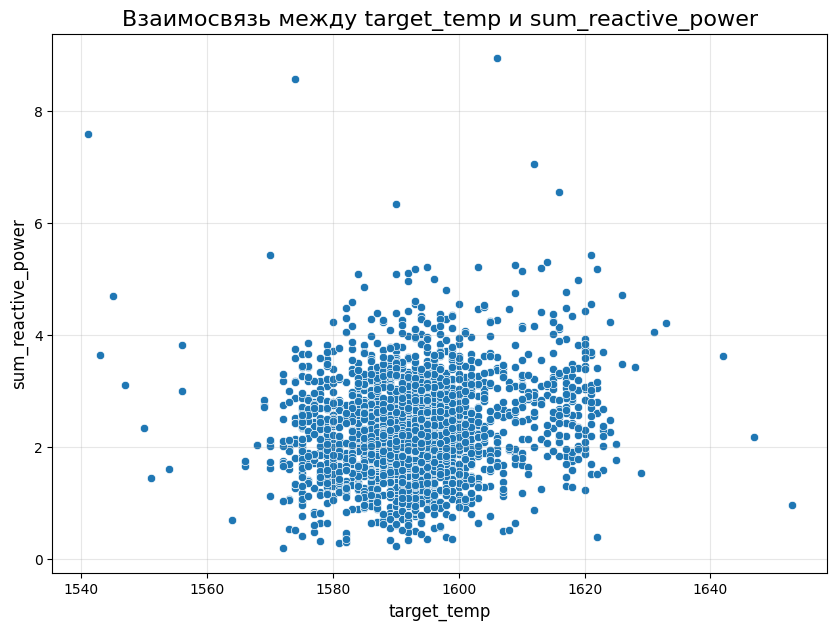

In [75]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'sum_reactive_power')

На графике линейная зависимость между входящим признаком `rsum_reactive_power` и целевым признаком `target_temp` отсутствует. Нелинейная зависимость также не наблюдается.

### Рассмотрим  признак `sum_full_power` — суммарная полная мощность для каждой партии.

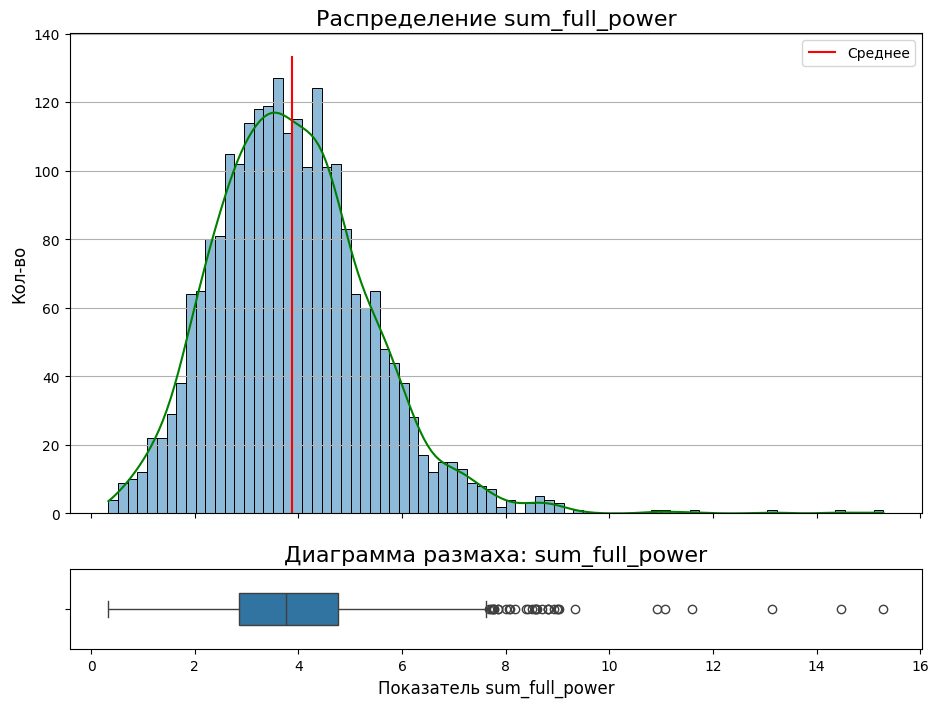

Описательные статистики:


count  mean   std   min   25%   50%   75%    max
sum_full_power  2329.0  3.88  1.52  0.33  2.84  3.77  4.77  15.29

Значение моды: 0.33


In [76]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'sum_full_power', 80)

Признак `sum_full_power` (суммарная полная мощность) имеет распределение со смещением вправо. Межквартильный размах суммарной полной мощности расположен в диапазоне от 2.84 до 4.77. Среднее значение суммарной полной мощности составляет 3.88. Имеются выбросы по правую часть "уса".

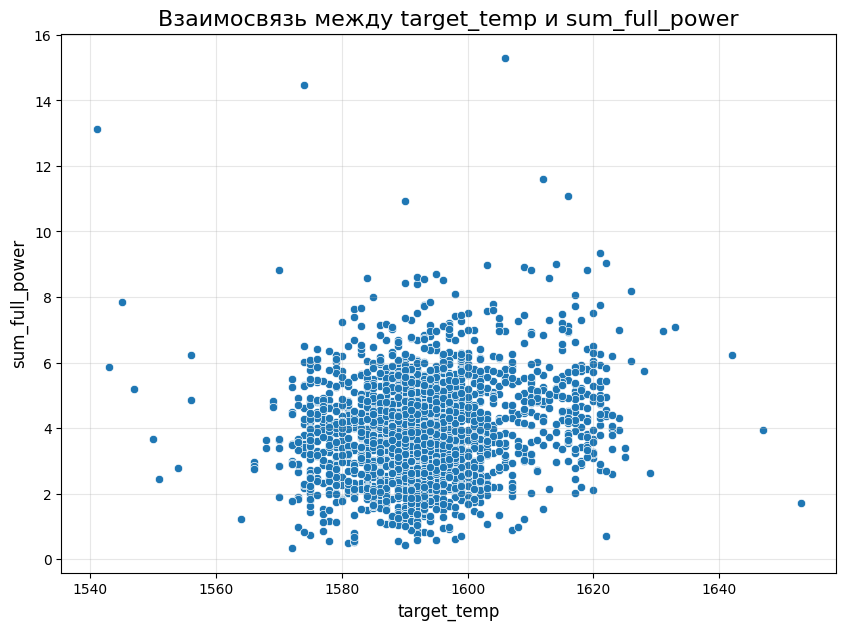

In [77]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'sum_full_power')

На графике линейная зависимость между входящим признаком `sum_full_power` и целевым признаком `target_temp` отсутствует. Нелинейная зависимость также не наблюдается.

### Рассмотрим признак `sum_time_heat` — суммарное время нагрева для каждой партии.

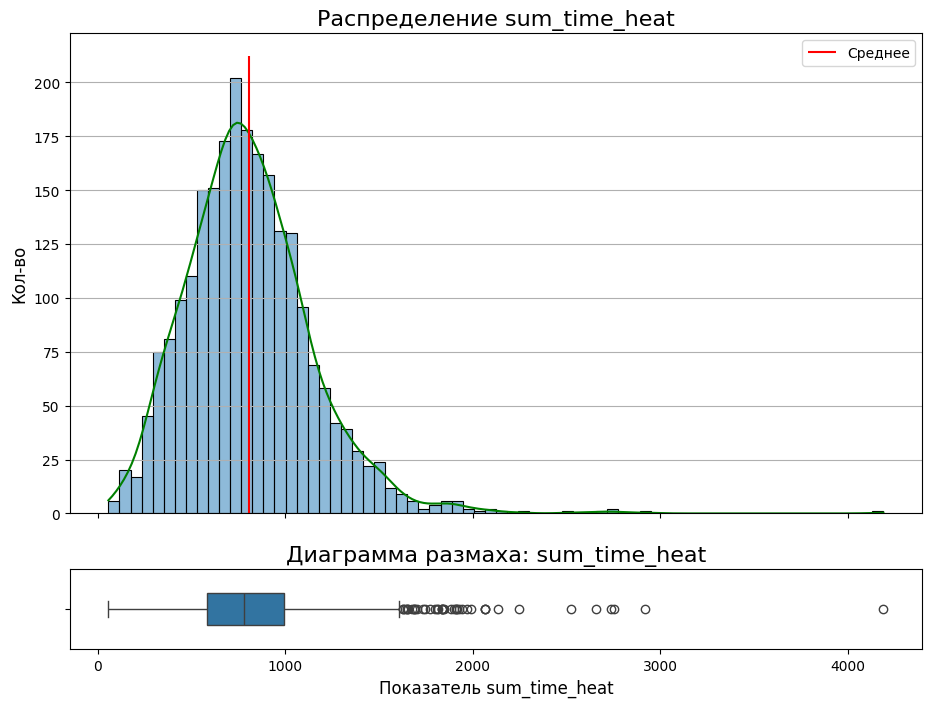

Описательные статистики:


count   mean    std   min    25%    50%    75%     max
sum_time_heat  2329.0  807.6  340.9  57.0  581.0  778.0  993.0  4189.0

Значение моды: 874.0


In [78]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'sum_time_heat', 70)

Признак `sum_time_heat` (суммарное время нагрева) имеет распределение со смещением вправо. Межквартильный размах суммарного времени нагрева расположен в диапазоне от 581 до 993. Среднее значение суммарного времени нагрева составляет 807.6. Имеются выбросы по правую часть "уса".

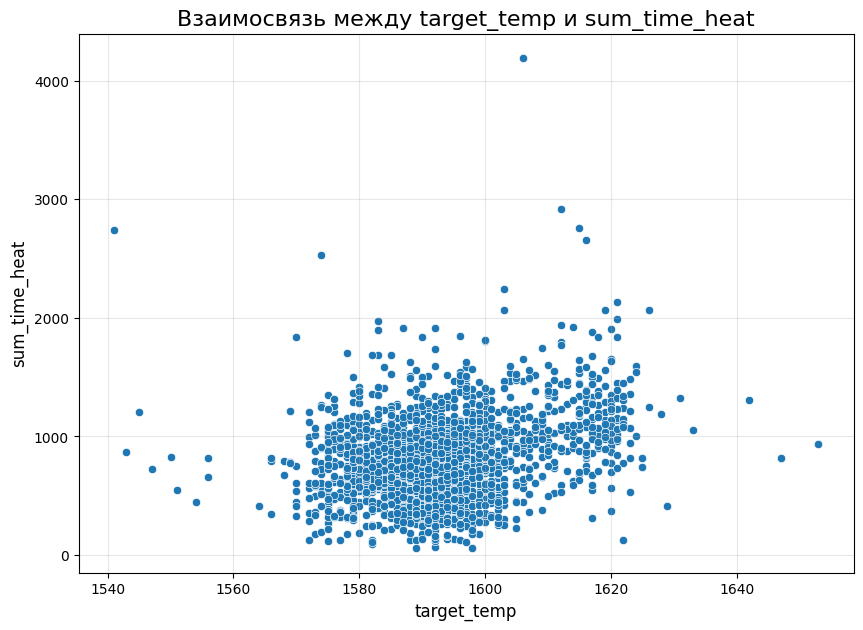

In [79]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'sum_time_heat')

На графике линейная зависимость между входящим признаком `sum_time_heat` и целевым признаком `target_temp` отсутствует. Нелинейная зависимость также не наблюдается.

### Рассмотрим  признак `gas_1` — объём подаваемого газа для каждой партии.

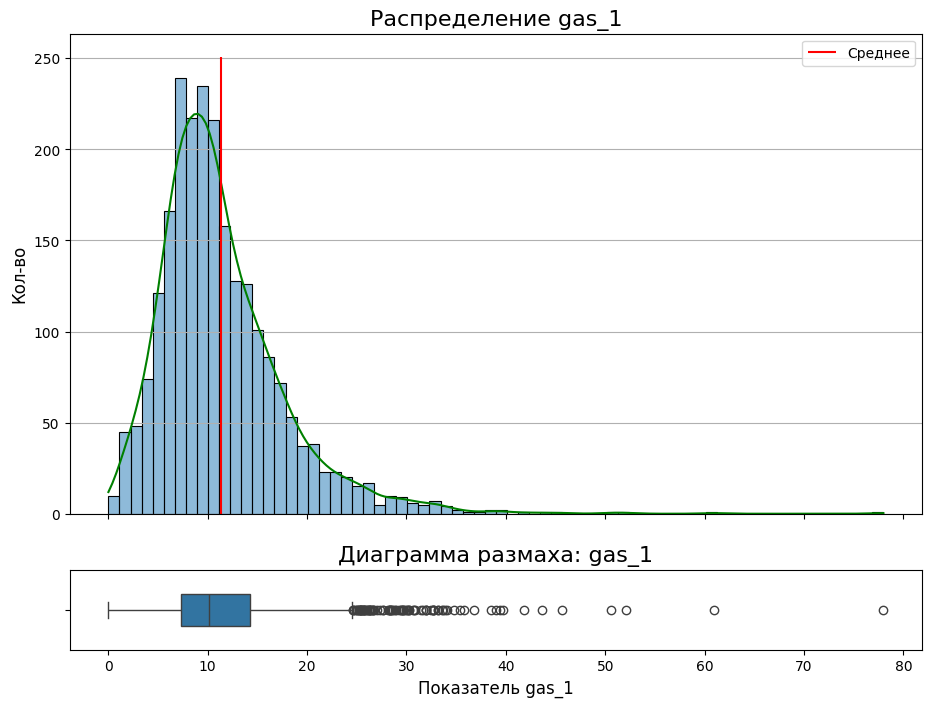

Описательные статистики:


count   mean   std   min   25%   50%    75%   max
gas_1  2329.0  11.38  6.39  0.01  7.28  10.1  14.22  78.0

Значение моды: 0.01


In [80]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'gas_1', 70)

Столбец `gas_1` (объем подаваемого газа) имеет аналогичное распределение как ранее в датасете `data_gas`: со смещением вправо. Межквартильный размах объема подаваемого газа расположен в диапазоне от 7 до 14. Средний объем подаваемого газа равен 11. Имеются выбросы в правой части "уса".

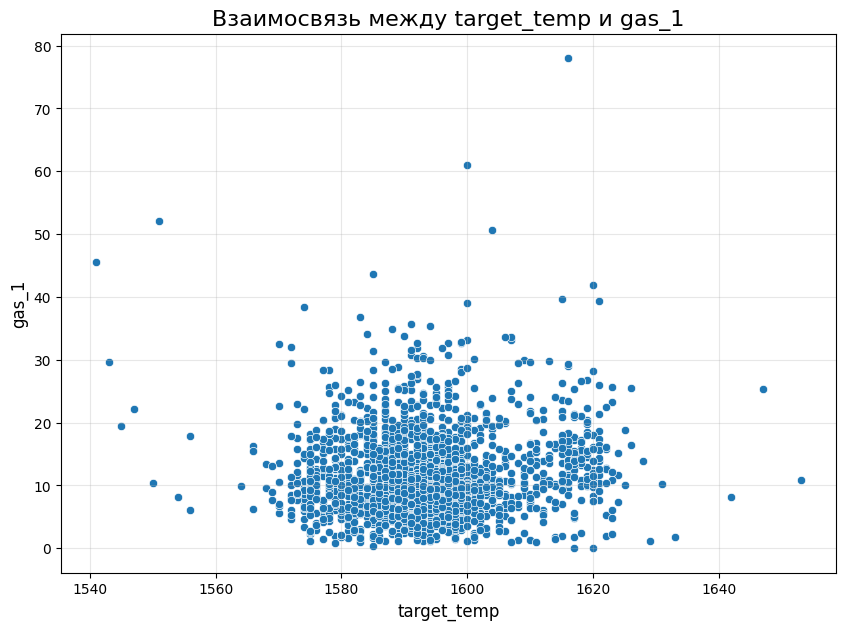

In [81]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'gas_1')

На графике линейная зависимость между входящим признаком `gas_1` и целевым признаком `target_temp` отсутствует. Нелинейная зависимость также не наблюдается.

### Рассмотрим  признак `bulk_3` — объем подаваемого сыпучего материала для каждой партии.

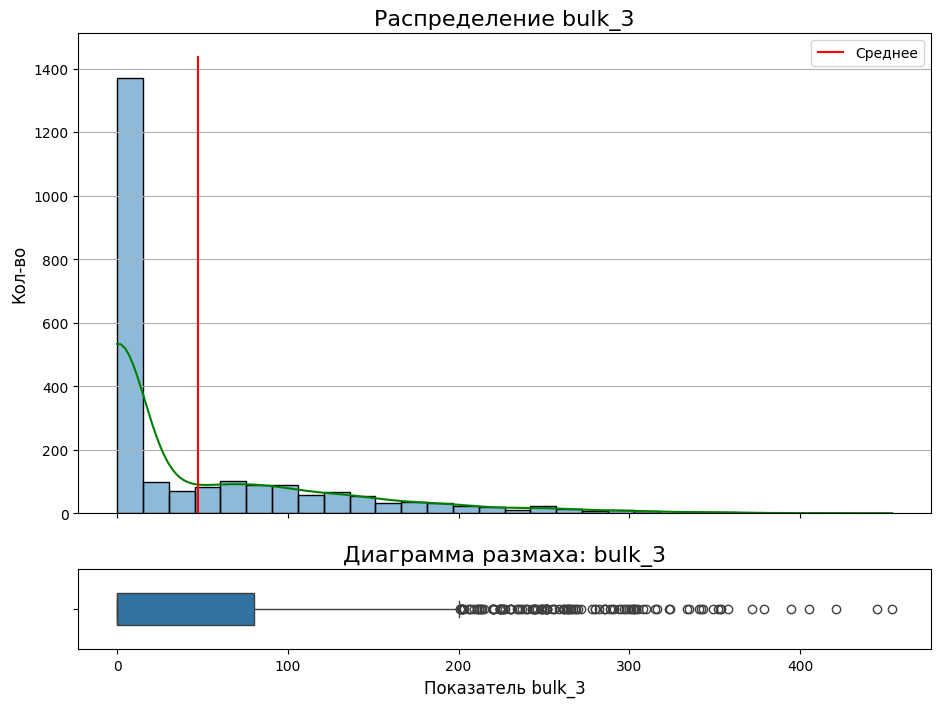

Описательные статистики:


count   mean    std  min  25%  50%   75%    max
bulk_3  2329.0  47.35  75.31  0.0  0.0  0.0  80.0  454.0

Значение моды: 0.0


In [82]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'bulk_3', 30)

Так как пропуски мы заполнили значением `0`, мы получили моду, равную `0`, из-за чего распределение признака `bulk_3` имеет асимметричное распределение с длинным правым хвостом. Это означает, что большинство значений сосредоточено в нижней части диапазона (это заполненные пропуски значением `0`), а высокие значения — выбросы — создают длинный правый хвост, хотя эти значения являются нормальными для данного типа сыпучих материалов. 

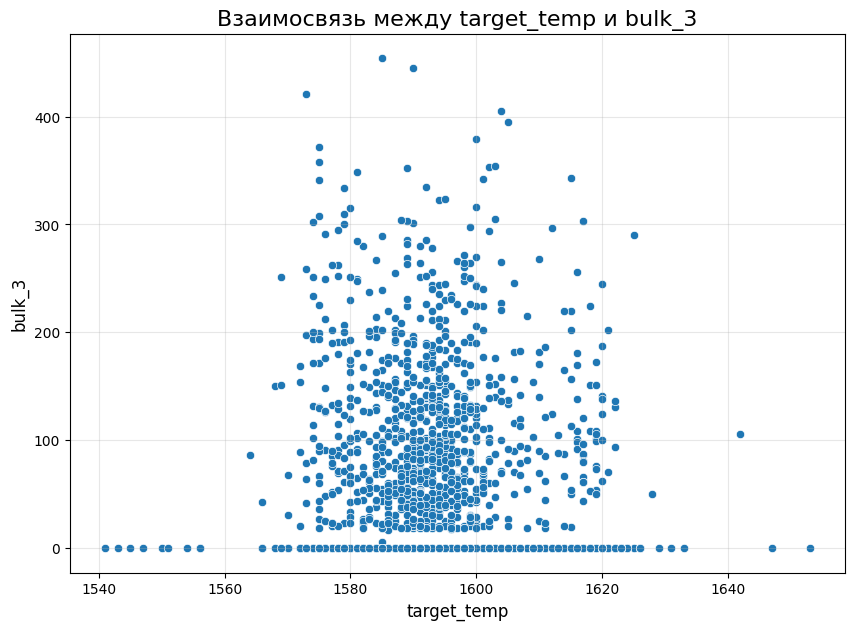

In [83]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'bulk_3')

На графике линейная зависимость между входящим признаком `bulk_3` и целевым признаком `target_temp` отсутствует, нелинейная зависимость также не наблюдается. Скопление точек, образовывающих линию со значением `bulk_3 = 0`, — это результат заполнения пропусков нулями.

### Рассмотрим  признак `bulk_4` — объем подаваемого сыпучего метериала для каждой партии.	

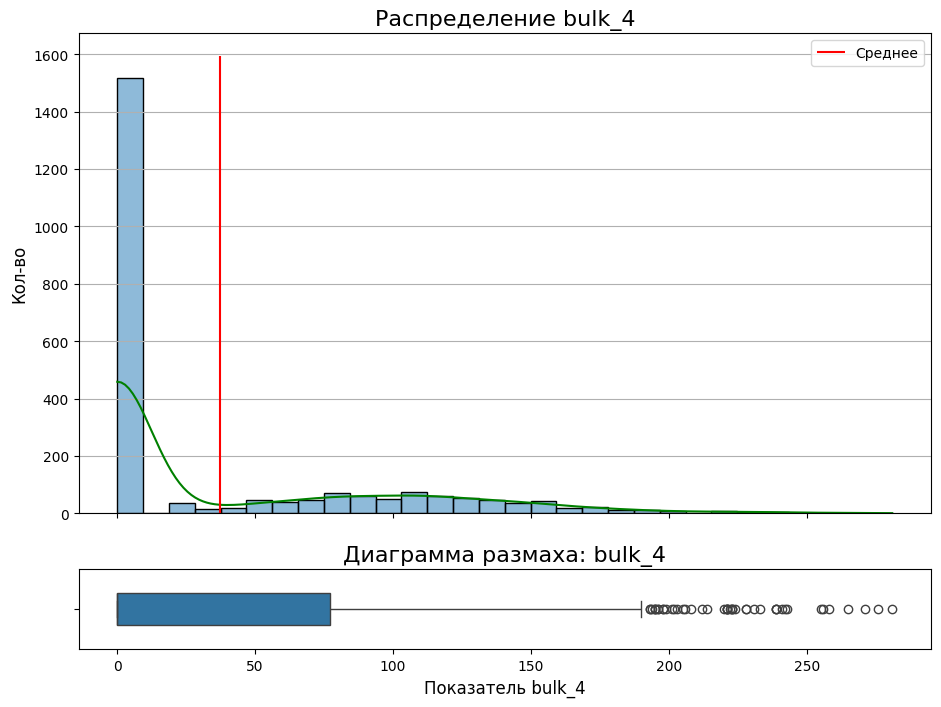

Описательные статистики:


count  mean    std  min  25%  50%   75%    max
bulk_4  2329.0  37.3  58.64  0.0  0.0  0.0  77.0  281.0

Значение моды: 0.0


In [84]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'bulk_4', 30)

Так как пропуски мы заполнили значением `0`, мы получили моду, равную `0`, из-за чего распределение признака `bulk_4` имеет асимметричное распределение с длинным правым хвостом. Это означает, что большинство значений сосредоточено в нижней части диапазона (это заполненные пропуски значением `0`), а высокие значения — выбросы — создают длинный правый хвост, хотя эти значения являются нормальными для данного типа сыпучих материалов.

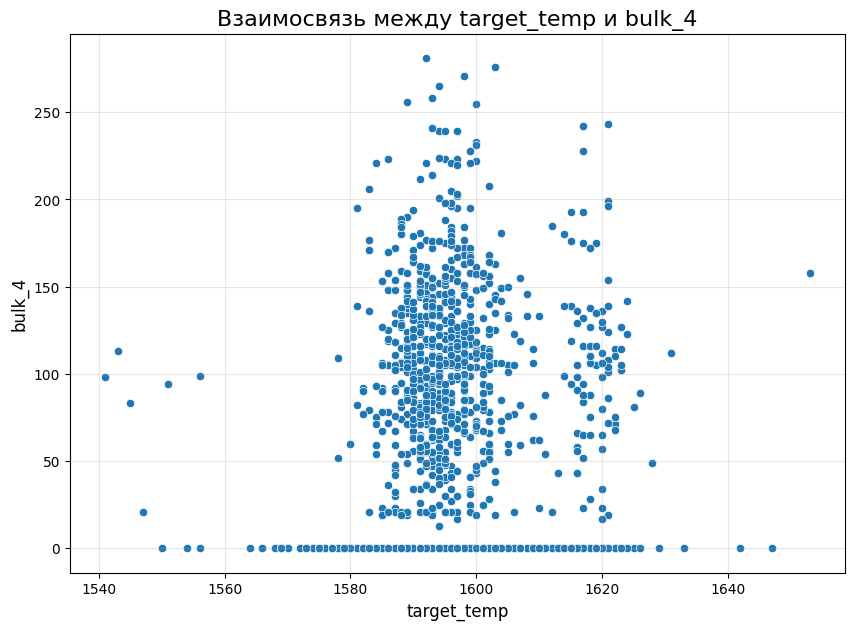

In [85]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'bulk_4')

На графике линейная зависимость между входящим признаком `bulk_4` и целевым признаком `target_temp` отсутствует, нелинейная зависимость также не наблюдается. Скопление точек, образовывающих линию со значением `bulk_4 = 0`, — это результат заполнения пропусков нулями.

### Рассмотрим  признак `bulk_6` — объем подаваемого сыпучего метериала для каждой партии.	

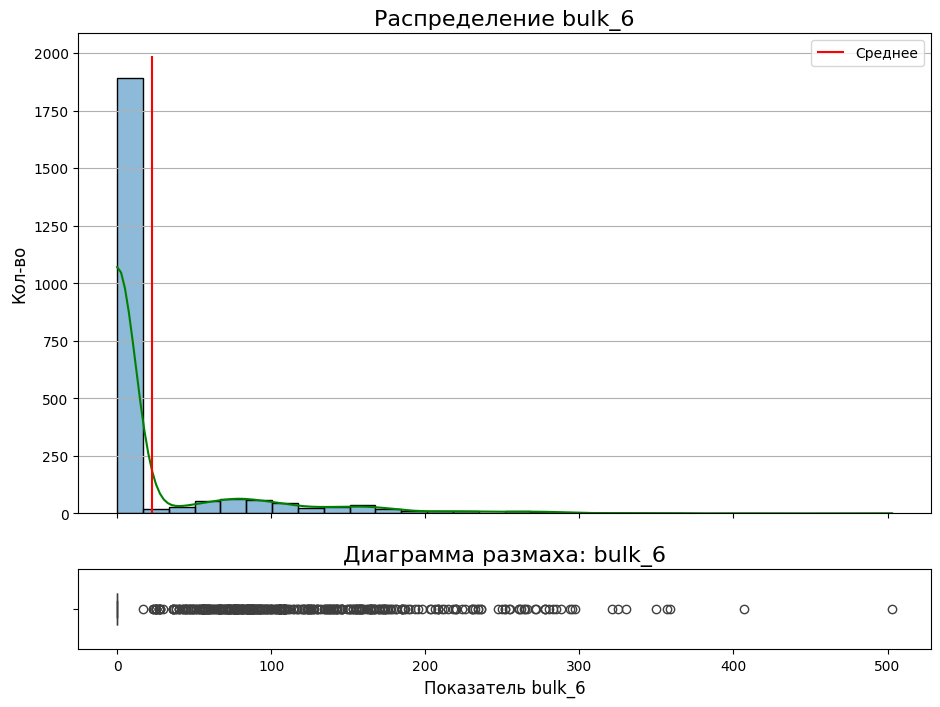

Описательные статистики:


count   mean    std  min  25%  50%  75%    max
bulk_6  2329.0  22.43  55.79  0.0  0.0  0.0  0.0  503.0

Значение моды: 0.0


In [86]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'bulk_6', 30)

Так как пропуски мы заполнили значением `0`, мы получили моду, равную `0`, из-за чего распределение признака `bulk_6` имеет асимметричное распределение с длинным правым хвостом. Это означает, что большинство значений сосредоточено в нижней части диапазона (это заполненные пропуски значением `0`), а высокие значения — выбросы — создают длинный правый хвост, хотя эти значения являются нормальными для данного типа сыпучих материалов.

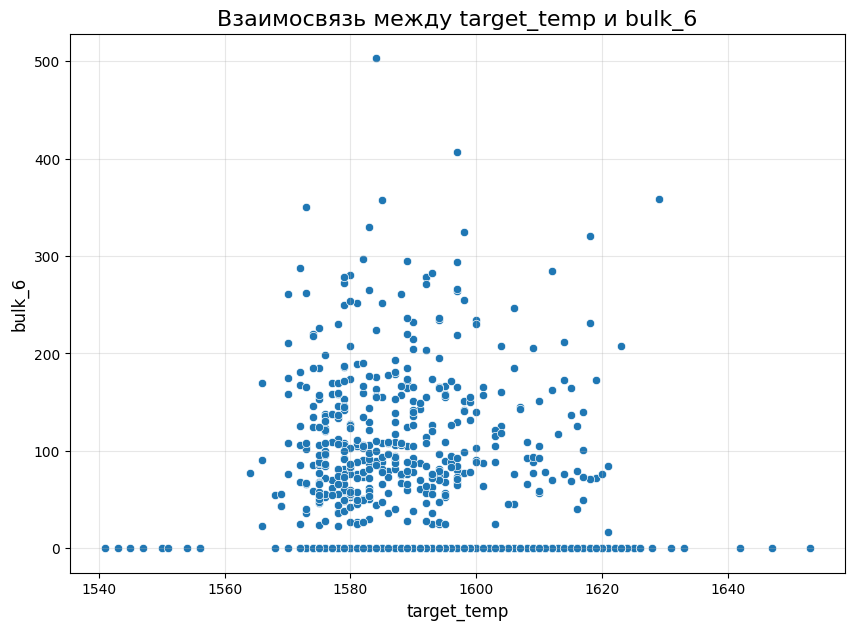

In [87]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'bulk_6')

На графике линейная зависимость между входящим признаком `bulk_6` и целевым признаком `target_temp` отсутствует, нелинейная зависимость также не наблюдается. Скопление точек, образовывающих линию со значением `bulk_6 = 0`, — это результат заполнения пропусков нулями.

### Рассмотрим  признак `bulk_12` — объем подаваемого сыпучего метериала для каждой партии.	

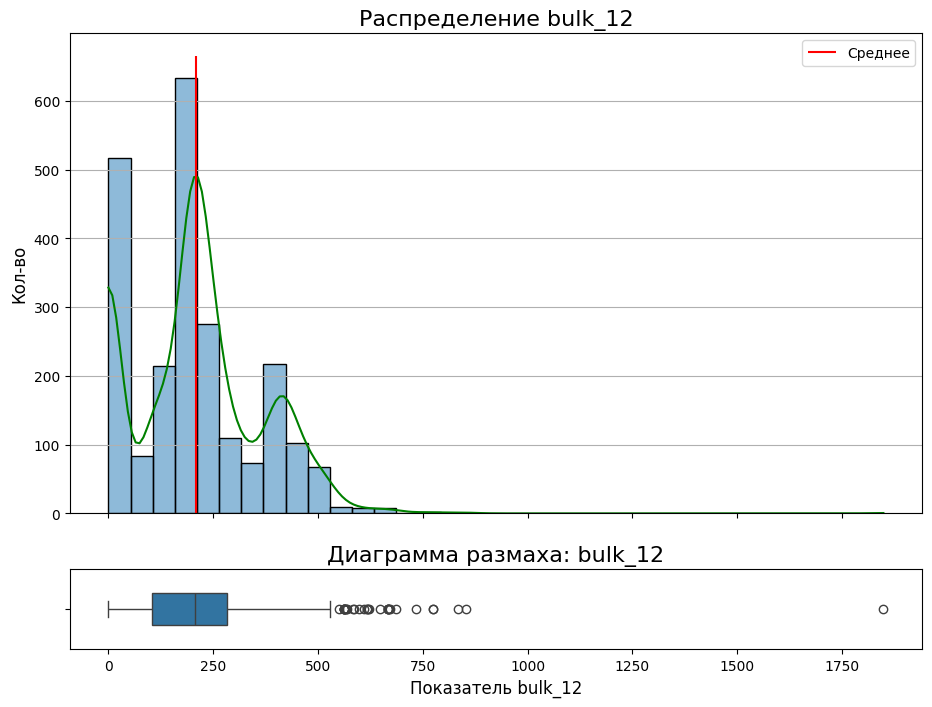

Описательные статистики:


count    mean     std  min    25%    50%    75%     max
bulk_12  2329.0  208.42  157.06  0.0  105.0  206.0  282.0  1849.0

Значение моды: 0.0


In [88]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'bulk_12', 35)

Заполнение пропусков значением `0` не так сильно изменило распределение признака `bulk_12`, в отличии от `bulk_3` и `bulk_4`, так как `bulk_12` изначально содержал меньшее кол-во пропусков. Тем не менее, распределение признака `bulk_12` имеет асимметричное распределение со смещением вправо. Выбросы создают правый хвост, хотя эти значения являются нормальными для данного типа сыпучих материалов, так как ранее мы заполняли пропуски значением 0, что повлияло на распределение данного признака. 

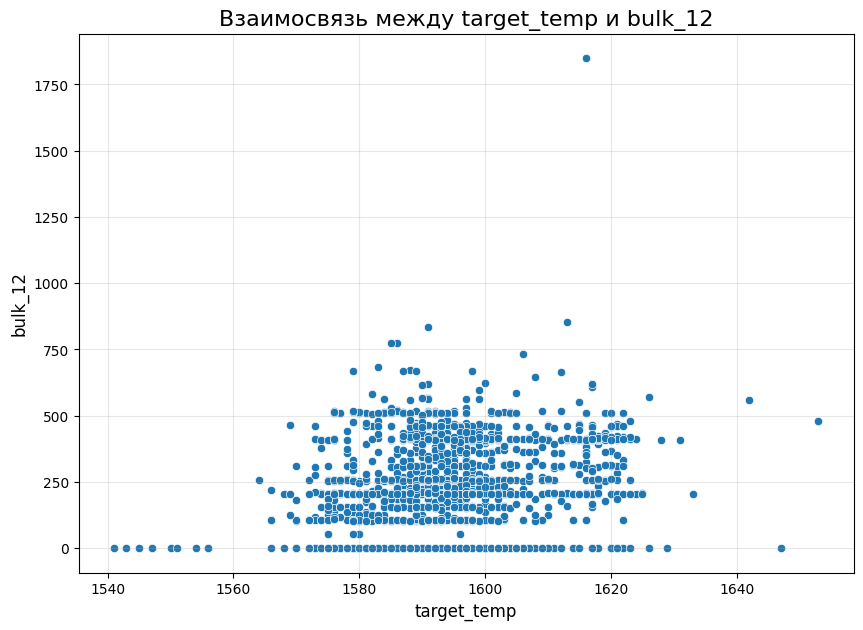

In [89]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'bulk_12')

На графике линейная зависимость между входящим признаком `bulk_12` и целевым признаком `target_temp` отсутствует, нелинейная зависимость также не наблюдается. Скопление точек, образовывающих линию со значением `bulk_12 = 0`, — это результат заполнения пропусков нулями.

### Рассмотрим  признак `bulk_14` — объем подаваемого сыпучего метериала для каждой партии.		

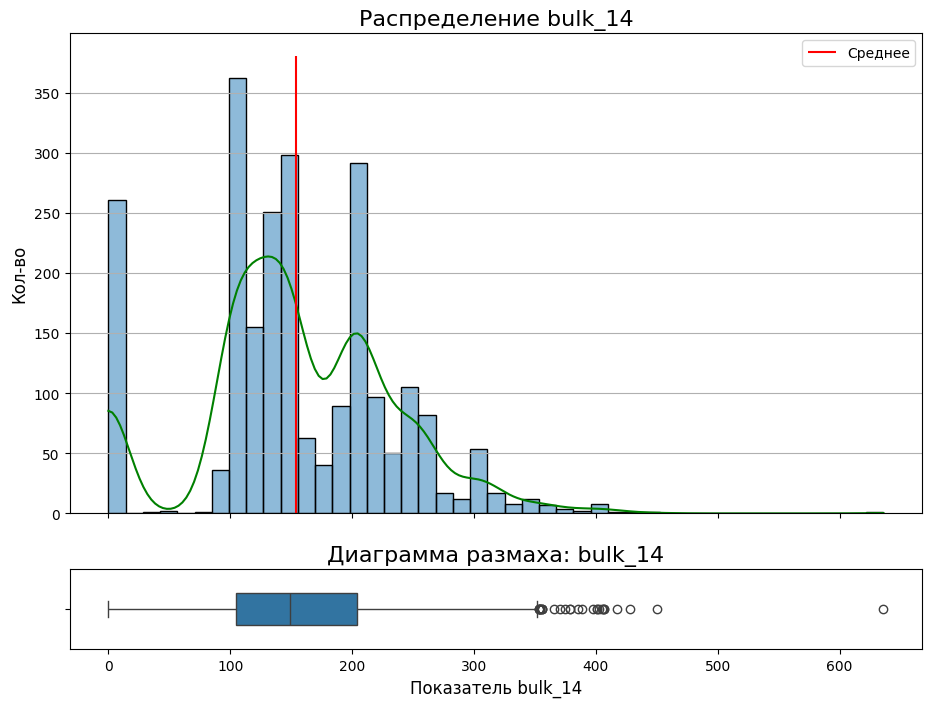

Описательные статистики:


count    mean   std  min    25%    50%    75%    max
bulk_14  2329.0  153.85  81.4  0.0  105.0  149.0  204.0  636.0

Значение моды: 0.0


In [90]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'bulk_14', 45)

Заполнение пропусков значением `0` не так сильно изменило распределение признака `bulk_14`, в отличии от `bulk_3` и `bulk_4`, так как `bulk_14` изначально содержал меньшее кол-во пропусков. Тем не менее, распределение признака `bulk_14` имеет асимметричное распределение со смещением вправо. Выбросы создают правый хвост, хотя эти значения являются нормальными для данного типа сыпучих материалов, так как ранее мы заполняли пропуски значением 0, что повлияло на распределение данного признака. 

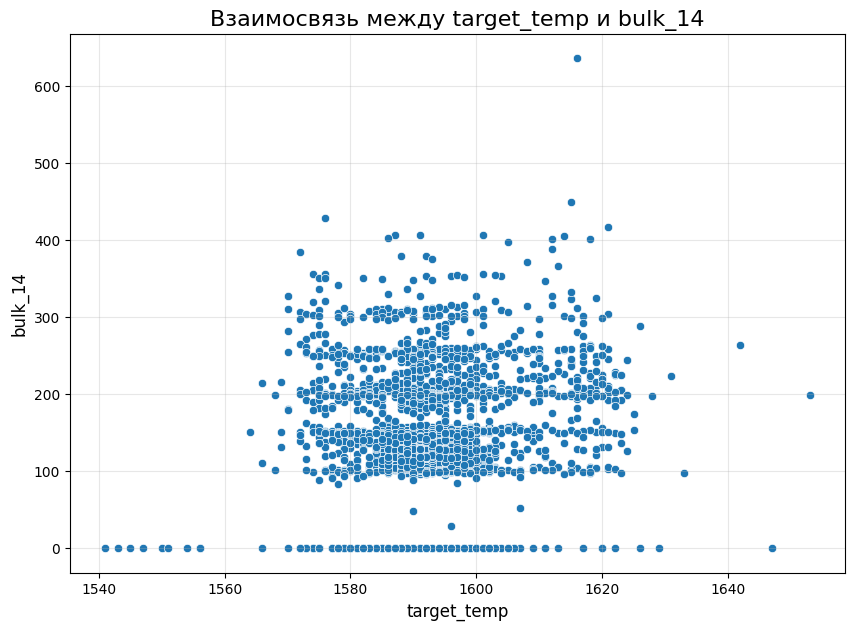

In [91]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'bulk_14')

На графике линейная зависимость между входящим признаком `bulk_14` и целевым признаком `target_temp` отсутствует, нелинейная зависимость также не наблюдается. Скопление точек, образовывающих линию со значением `bulk_14 = 0`, — это результат заполнения пропусков нулями.

### Рассмотрим  признак `bulk_15` — объем подаваемого сыпучего метериала для каждой партии.		

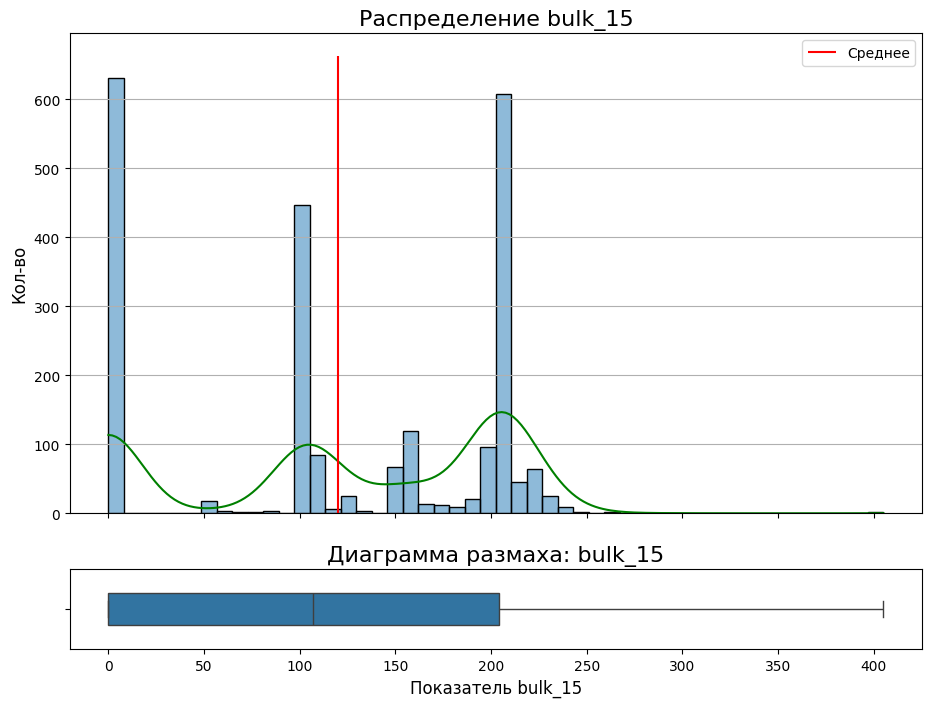

Описательные статистики:


count    mean    std  min  25%    50%    75%    max
bulk_15  2329.0  119.95  84.64  0.0  0.0  107.0  204.0  405.0

Значение моды: 0.0


In [92]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'bulk_15', 50)

Признак `bulk_15` имеет асимметричное распределение со смещением вправо. Выбросы отсутствуют. Имеются явные три группы скоплений наблюдений признака `bulk_15` у значений 0, 100 и 200 — это наиболее распространенные объемы подаваемого сыпучего материала. 

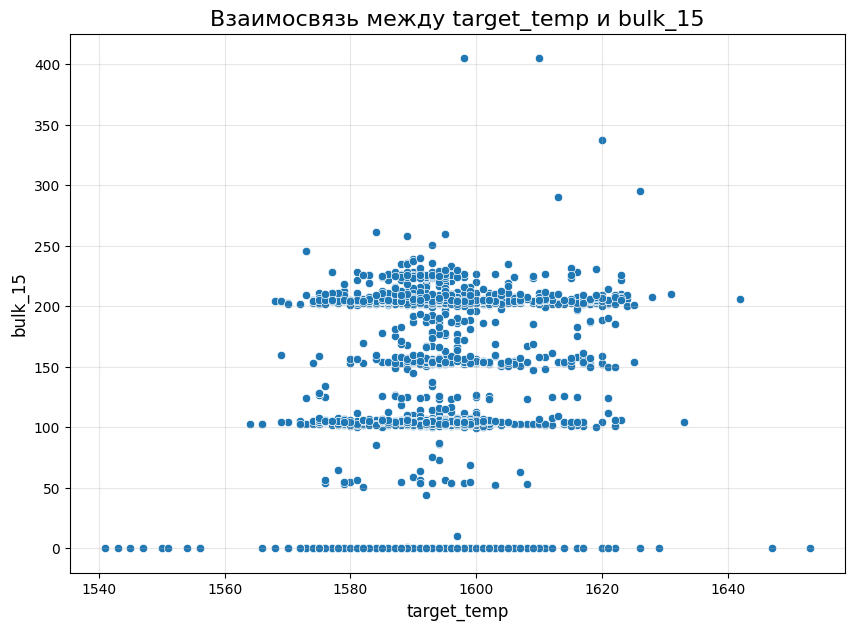

In [93]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'bulk_15')

На графике линейная зависимость между входящим признаком `bulk_15` и целевым признаком `target_temp` отсутствует, нелинейная зависимость также не наблюдается. Скопление точек, образовывающих линию со значением `bulk_15 = 0`, — это результат заполнения пропусков нулями. Также можно отметить скопление точек у значений `bulk_15` 100, 150 и 200. 

### Рассмотрим  признак `wire_1` — объем подаваемого проволочного материала для каждой партии.	

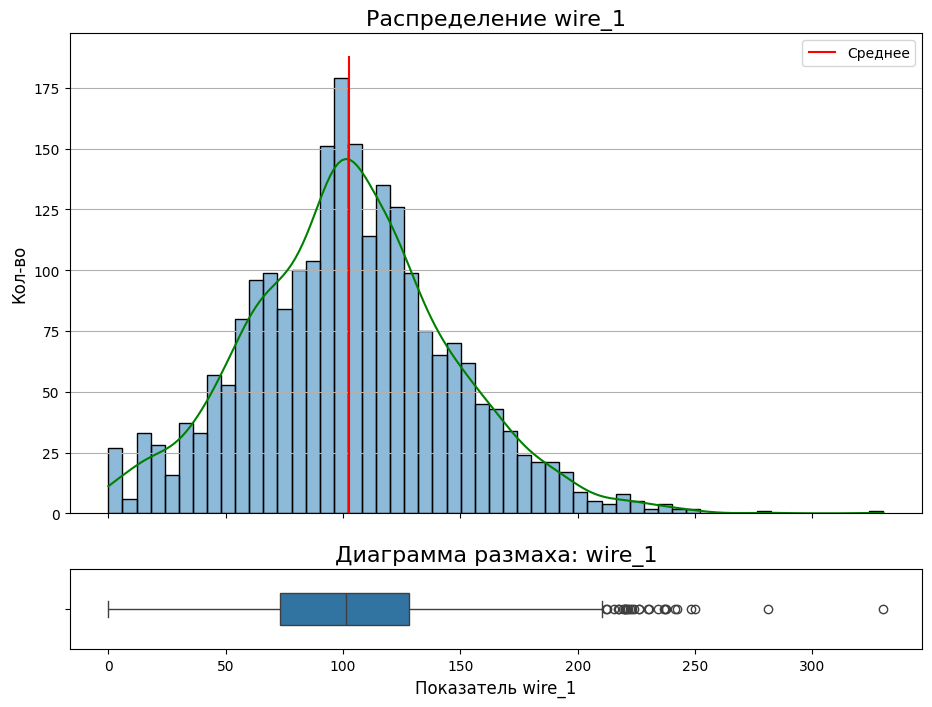

Описательные статистики:


count    mean    std  min    25%     50%     75%     max
wire_1  2329.0  102.44  43.54  0.0  73.21  101.12  128.09  330.31

Значение моды: 0.0


In [94]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'wire_1', 55)

Признак `wire_1` имеет распределение со смещением вправо, из-за заполнения пропусков значением `0`.  Межквартильный размах значения активной мощности расположен в диапазоне от 73 до 128. Среднее значение составляет 102. Имеются выбросы в правой части "уса".

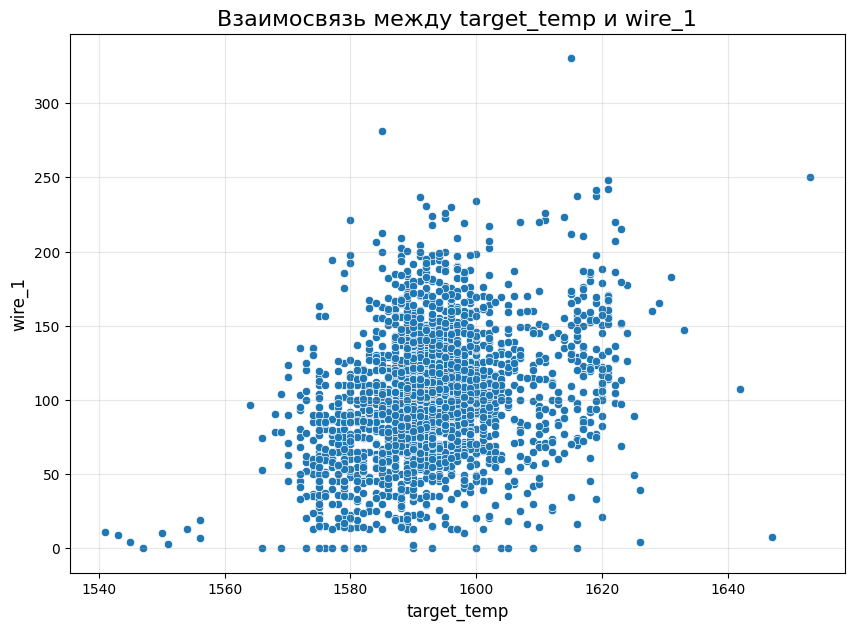

In [95]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'wire_1')

На графике линейная зависимость между входящим признаком `wire_1` и целевым признаком `target_temp` отсутствует. Нелинейная зависимость также не наблюдается.

### Рассмотрим  признак `wire_2` — объем подаваемого проволочного материала для каждой партии.

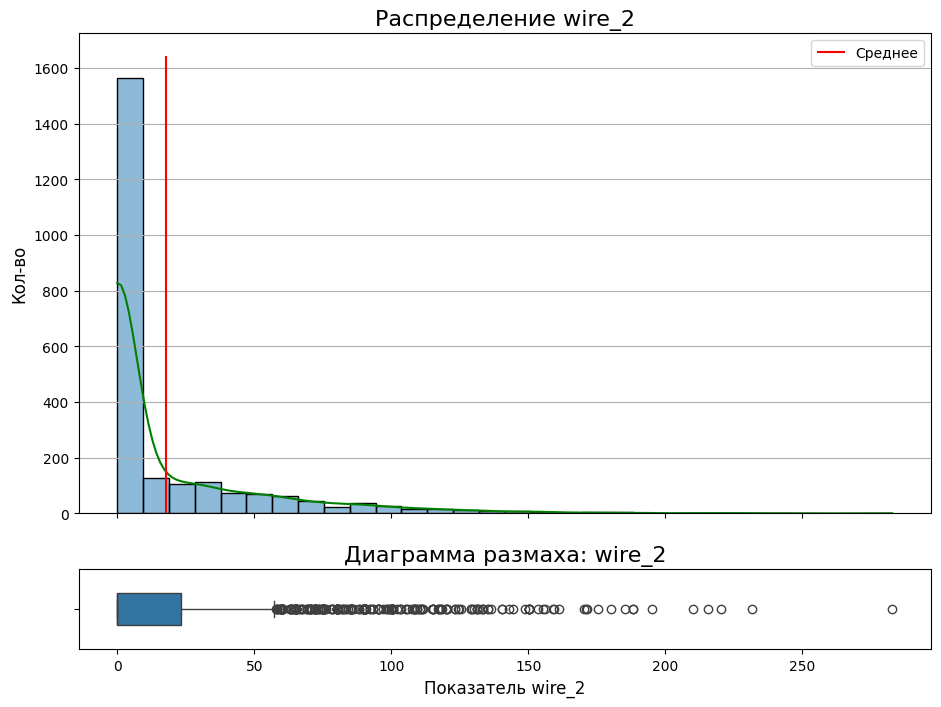

Описательные статистики:


count   mean    std  min  25%  50%   75%     max
wire_2  2329.0  17.61  33.62  0.0  0.0  0.0  23.1  282.78

Значение моды: 0.0


In [96]:
# Построим гистограмму и диаграмму размаха функцией histbox(data, column, bins)
histbox(df_total, 'wire_2', 30)

Так как пропуски мы заполнили значением `0`, мы получили моду, равную `0`, из-за чего распределение признака `wire_2` имеет асимметричное распределение с длинным правым хвостом. Это означает, что большинство значений сосредоточено в нижней части диапазона (это заполненные пропуски значением `0`), а высокие значения — выбросы — создают длинный правый хвост, хотя эти значения являются нормальными для данного типа проволочных материалов. 

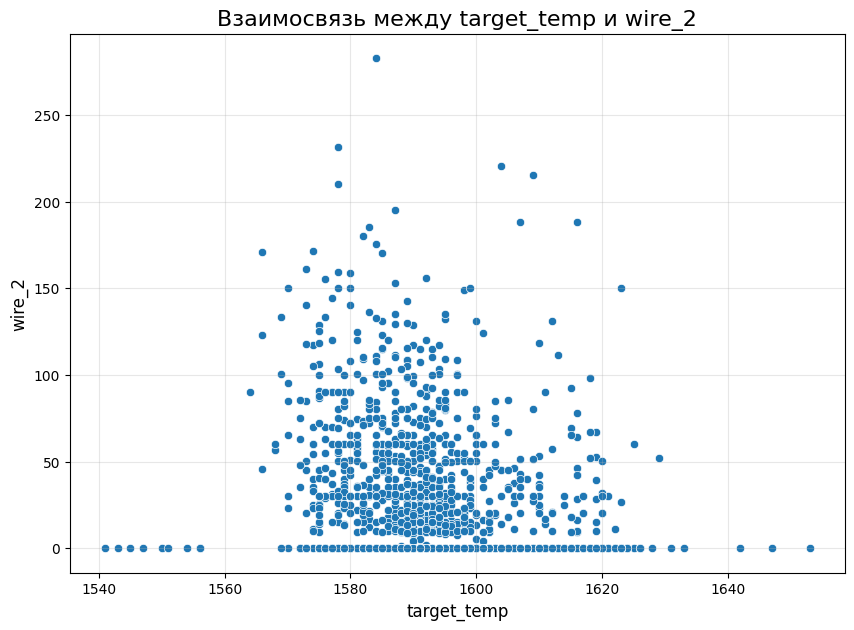

In [97]:
# Построим диаграмму рассеяния функцией scatplot(data, column_1, column_2)
scatplot(df_total, 'target_temp', 'wire_2')

На графике линейная зависимость между входящим признаком `wire_2` и целевым признаком `target_temp` отсутствует, нелинейная зависимость также не наблюдается. Скопление точек, образовывающих линию со значением `wire_2 = 0`, — это результат заполнения пропусков нулями.

### Промежуточный итог:

Мы провели исследовательский анализ датасета `df_total` и выяснили следующее:


- Целевой признак `target_temp` имеет нормальное распределение. Средний показатель последней температуры составляет 1593. Количество и размер выбросов сократились в сравнении с изначальным распределением столбца `temperature` датасета `data_temp`. 


- Признак `temperature` имеет нормальное распределение: среднее, медиана и мода практически совпадают. Средний показатель температуры составляет 1588. Количество и размер выбросов сократились в сравнении с изначальным распределением столбца `temperature` датасета `data_temp`.  Средний показатель первой температуры на 5 ниже среднего показателя последней температуры сплава (средний показатель 1588 у первого замера и 1593 у последнего).


- Признак `sum_active_power` (суммарная активная мощность) имеет распределение со смещением вправо. Среднее значение активной мощности составляет 0.66. Имеются незначительное количество выбросов в левой части "уса" и большее их количество по правую часть "уса".


- Признак `sum_reactive_power` (суммарная реактивная мощность) имеет распределение со смещением влево. Среднее значение суммарной реактивной мощности составляет 2.3. Имеется незначительное количество выбросов в левой части "уса" и большее их количество по правую часть "уса".


- Признак `sum_full_power` (суммарная полная мощность) имеет распределение со смещением вправо. Среднее значение суммарной полной мощности составляет 3.88. Имеются выбросы по правую часть "уса".


- Признак `sum_time_heat` (суммарное время нагрева) имеет распределение со смещением вправо. Среднее значение суммарного времени нагрева составляет 807.6. Имеются выбросы по правую часть "уса".


- Признак `gas_1` (объем подаваемого газа) имеет аналогичное распределение как ранее в датасете `data_gas`: со смещением вправо. Средний объем подаваемого газа равен 11. Имеются выбросы в правой части "уса".



- Признаки `bulk_3`, `bulk_4`, `bulk_6`, `bulk_12`, `bulk_14` имеют асимметричное распределение с длинным правым хвостом. Большинство значений сосредоточено в нижней части диапазона (это заполненные пропуски значением `0`), а высокие значения — выбросы — создают длинный правый хвост, хотя эти значения являются нормальными для данных типов сыпучих материалов.


- Признак `bulk_15` имеет асимметричное распределение со смещением вправо. Выбросы отсутствуют. Имеются явные три группы скоплений наблюдений признака `bulk_15` у значений 0, 100 и 200 — это наиболее распространенные объемы подаваемого сыпучего материала. 


- Признак `wire_1` имеет распределение со смещением вправо, из-за заполнения пропусков значением `0`. Среднее значение составляет 102. Имеются выбросы в правой части "уса".


- Распределение признака `wire_2` имеет асимметричное распределение с длинным правым хвостом. Большинство значений сосредоточено в нижней части диапазона (это заполненные пропуски значением `0`), а высокие значения — выбросы — создают длинный правый хвост, хотя эти значения являются нормальными для данного типа проволочных материалов. 


- Линейная и нелинейная зависимость входящих признаков `temperature`, `sum_active_power`, `sum_reactive_power`, `sum_full_power`, `sum_time_heat`, `gas_1`, `bulk_3`, `bulk_4`, `bulk_6`, `bulk_12`, `bulk_14`, `bulk_14`, `wire_1`, `wire_2` с целевым признаком **`target_temp`** отсутствует. 

## Корреляционный анализ признаков.

В исследовательском анализе признаков датасета `df_total` мы выяснили, что большинство признаков не распределены нормально, а имеют ассиметричное распределение со смещением вправо или влево, а также выявили отсутствие линейной и нелинейной зависимости входящих признаков с целевым, поэтому для проведения корреляционного анализа будем использовать корреляцию Спирмена.

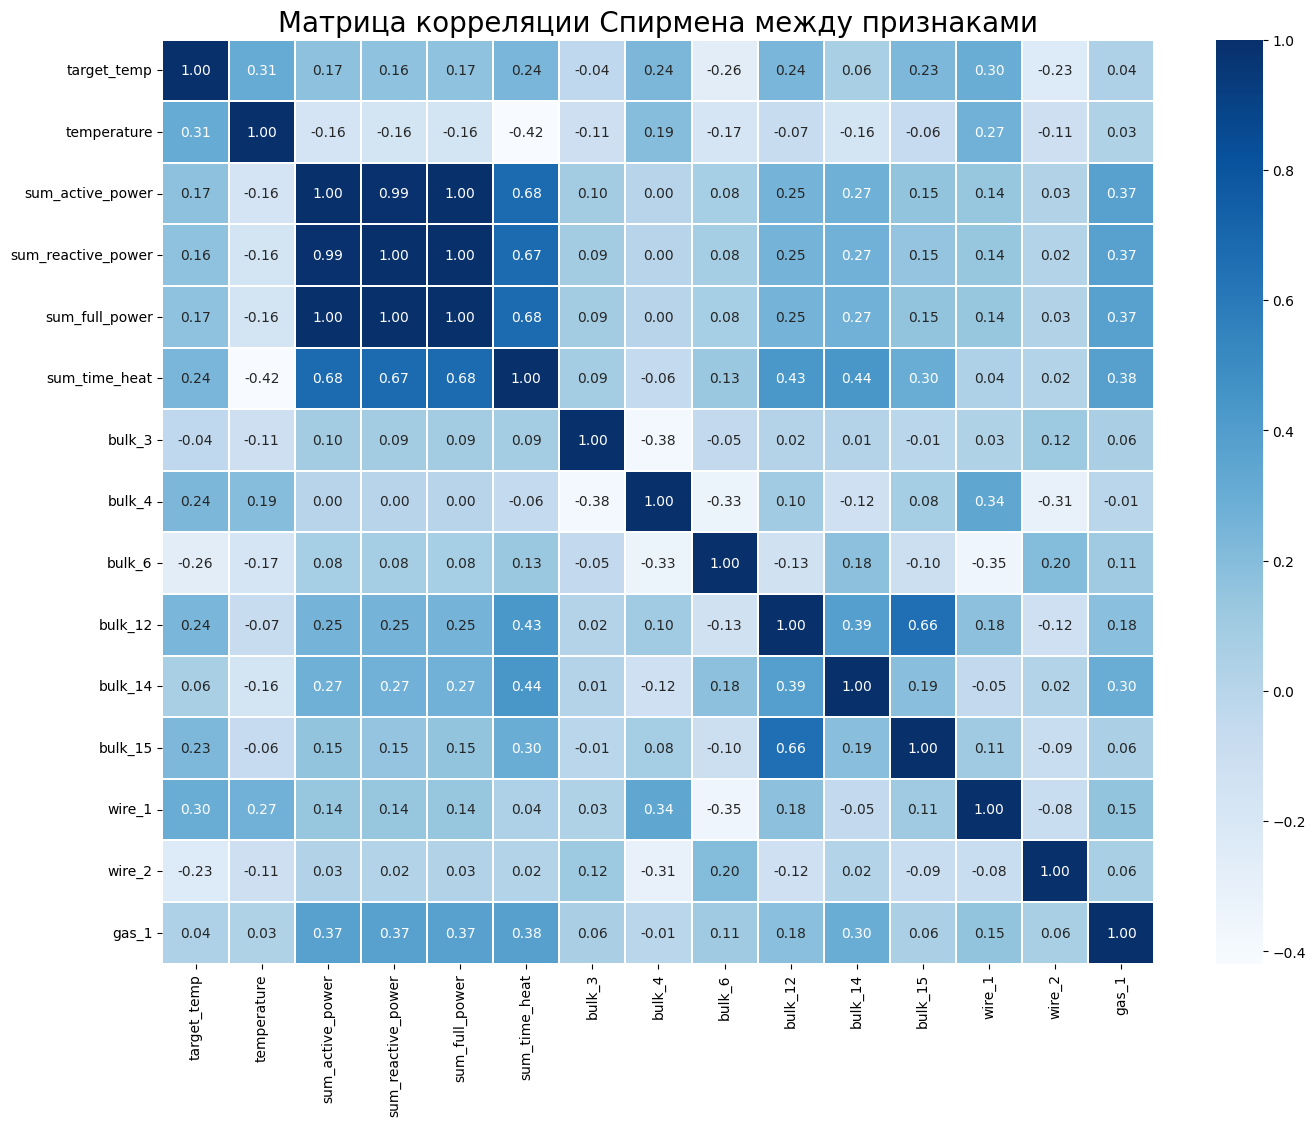

In [98]:
# # Построим матрицу корреляции Спирмена с помощью тепловой карты heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df_total.corr(method='spearman'), annot=True, fmt='.2f', cmap='Blues', linewidths=0.1)
plt.title('Матрица корреляции Спирмена между признаками', fontsize=20)
plt.show()

Коэффициент корреляции Спирмена находится в отрезке `[-1, 1]`, где:

- `-1` — идеальная отрицательная связь (с ростом одной переменной другая уменьшается);
- `0` — нет связи;
- `1` — идеальная положительная связь (с ростом одной переменной другая увеличивается).

С целевым признаком **`target_temp`**:


- *Слабую положительную корреляцию* (от 0,3 до 0,5) имеют входные признаки:

   - `temperature` (коэф. 0.31) — показатель первой температуры сплава партии;
   - `wire_1` (коэф. 0.30) — объем подаваемого проволочного материала для каждой партии;
   
   
- *Незначительную положительную корреляцию* (от 0,0 до 0,3) имеют входные признаки:

   - `sum_time_heat` (коэф. 0.24) — суммарное время нагрева для каждой партии;
   - `bulk_4` (коэф. 0.24) — объем подаваемого сыпучего метериала для каждой партии;		
   - `bulk_12` (коэф. 0.24) — объем подаваемого сыпучего метериала для каждой партии;
   - `bulk_15` (коэф. 0.23) — объем подаваемого сыпучего метериала для каждой партии;	
   - `bulk_14` (коэф. 0.06) — объем подаваемого сыпучего метериала для каждой партии;	
   - `sum_active_power` (коэф. 0.17) — сумма значений активных мощностей для каждой партии;
   - `sum_full_power` (коэф. 0.17) — сумма значений полных мощностей для каждой партии;
   - `sum_reactive_power` (коэф. 0.16) — сумма значений реактивных мощностей для каждой партии;
   - `gas_1` (коэф. 0.04) — объём подаваемого газа для каждой партии.
   
   
- *Незначительную отрицательную корреляцию* (от 0,0 до -0,3) имеют входные признаки

   - `bulk_6` (коэф. -0.26) — объем подаваемого сыпучего материала для каждой партии;
   - `wire_2` (коэф. -0.23) — объем подаваемого проволочного материала для каждой партии;
   - `bulk_3` (коэф. -0.04) — объем подаваемого сыпучего материала для каждой партии;	 


- Входящие признаки `sum_active_power` и `sum_reactive_power` и `sum_full_power` являются *мультикоррелирующими* (коэф. больше 0.9), что негативно повлияет на обучение линейных моделей. Поэтому для обучения линейных моделей оставим признак `full_mean_power`, так как он содержит в себе показатели активной и реактивной мощностей. 

## Подготовка данных для обучения моделей. Обучение моделей машинного обучения и выбор лучшей модели.

### Подготовка данных и обучение модели `LinearRegression` . 

Для обучения модели `LinearRegression` исключим мультикоррелирующие входные признаки `sum_active_power` и `sum_reactive_power`. После разобьем данные на тренировочную и тестовую выборки в соотношении 3:1.

In [99]:
# Сохраним входные признаки в переменную X
X = df_total.drop(['sum_active_power', 'sum_reactive_power', 'target_temp'], axis=1)

X.head()

temperature  sum_full_power  sum_time_heat  bulk_3  bulk_4  bulk_6  \
key                                                                       
1         1571.0        3.718736         1098.0     0.0    43.0     0.0   
2         1581.0        2.588349          811.0     0.0    73.0     0.0   
3         1596.0        5.019223          655.0     0.0    34.0     0.0   
4         1601.0        3.400038          741.0     0.0    81.0     0.0   
5         1576.0        2.816980          869.0     0.0    78.0     0.0   

     bulk_12  bulk_14  bulk_15     wire_1   wire_2      gas_1  
key                                                            
1      206.0    150.0    154.0  60.059998  0.00000  29.749986  
2      206.0    149.0    154.0  96.052315  0.00000  12.555561  
3      205.0    152.0    153.0  91.160157  0.00000  28.554793  
4      207.0    153.0    154.0  89.063515  0.00000  18.841219  
5      203.0    151.0    152.0  89.238236  9.11456   5.413692

Входные признаки сохранены успешно (исключили мультикоррелирующие признаки `active_mean_power` и `reactive_mean_power`, также целевой признак `target_temp`).

In [100]:
# Сохраним целевой признак в переменную y
y = df_total['target_temp']

y.head().to_frame()

target_temp
key             
1         1613.0
2         1602.0
3         1599.0
4         1625.0
5         1602.0

Целевой признак в переменную `y` сохранен успешно. 

In [101]:
# Разделим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=RANDOM_STATE
) 

Обучим модель линейной регрессии `LinearRegression`. Создадим пайплайн для масштабирования данных и вызова модели.

In [102]:
# Cоздадим пайплайн: подготовка данных и модель
pipe_lg = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])

Cоздадим список с гиперпараметрами для `GridSearchCV`.

In [103]:
# Cоздадим список с гиперпараметрами
param_grid = [
    {
        'model': [LinearRegression()], 
        'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    } 
]

Подбор гиперпараметров будем проводить с помощью `GridSearchCV`, а для оценки качества модели будем использовать метрику `MAE`.

In [104]:
# Используем GridSearchCV
grid_search = GridSearchCV(
    pipe_lg, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)

Обучим наши модели с гиперпараметрами и выведем лучшую модель и ее метрику.

In [105]:
# Запускаем поиск гиперпараметров
%time grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:', grid_search.best_params_)
print('Метрика MAE лучшей модели на кросс-валидации:', -grid_search.best_score_)

CPU times: user 55.8 ms, sys: 110 ms, total: 166 ms
Wall time: 2.36 s
Лучшая модель и её параметры: {'model': LinearRegression(), 'scaler': StandardScaler()}
Метрика MAE лучшей модели на кросс-валидации: 6.352835277515364


По итогам работы `GridSearchCV` наилучшим образом справилась модель `LinearRegression()` без масштабирования прзнаков. Метрика `MAE` на кросс-валидации составила `6.35`. 

### Подготовка данных и обучение моделей градиентного бустинга `LGBMRegressor` .

Для обучения моделей градиентного бустинга `LGBMRegressor` будем использовать все доступные входные признаки, в том числе и мультикоррелирующие, так как мультикорреляция признаков не имеет такого же негативного влияния, как на линейные модели. 

In [106]:
# Сохраним входные признаки в переменную X_boost
X_boost = df_total.drop('target_temp', axis=1)

In [107]:
# Сохраним целевой признак в переменную y_boost
y_boost = df_total['target_temp']

In [108]:
# Разделим на тренировочную и тестовую выборки
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(
    X_boost, 
    y_boost, 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

Подбор гиперпараметров для модели градиентного бустинга `LGBMRegressor` будем проводить с помощью `OptunaSearchCV`. Cоздадим пайплайн с моделью `LGBMRegressor()`.

In [109]:
# Пайплайн с моделью LGBMRegressor
pipe_lgbm = Pipeline(
    [
        ('model', lgb.LGBMRegressor(
            objective='regression', metric='neg_mean_absolute_error', random_state=RANDOM_STATE)
        )
    ]
)

Cоздадим список с гиперпараметрами для `OptunaSearchCV`.

In [110]:
# Параметры для Optuna
parameters_lgbm = {
    'model__max_depth': optuna.distributions.IntDistribution(3, 50),
    'model__n_estimators': optuna.distributions.IntDistribution(10, 1000),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.1)
}

In [111]:
# Инициализируем OptunaSearchCV
oscv_lgbm = OptunaSearchCV(
    pipe_lgbm,
    parameters_lgbm,
    random_state=RANDOM_STATE,
    cv=5,
    verbose=0,
    scoring='neg_mean_absolute_error',
    n_trials=30
) 

In [112]:
# Запускаем поиск гиперпараметров
%time oscv_lgbm.fit(X_train_boost, y_train_boost)

# Лучшие гиперпараметры
print(f'Оптимальные гиперпараметры: {oscv_lgbm.best_params_}')

# Лучшая метрику качества
print(f'\nЛучшая метрика MAE на кросс-валидации: {-oscv_lgbm.best_score_:.4f}')

[I 2025-08-18 17:56:39,838] A new study created in memory with name: no-name-ad72de8d-6bf5-4927-8df7-38caa806ff0e


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [

[I 2025-08-18 17:56:41,834] Trial 0 finished with value: -6.575782701722337 and parameters: {'model__max_depth': 21, 'model__n_estimators': 567, 'model__learning_rate': 0.06650047644627687}. Best is trial 0 with value: -6.575782701722337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:56:44,981] Trial 1 finished with value: -6.587947627668173 and parameters: {'model__max_depth': 50, 'model__n_estimators': 872, 'model__learning_rate': 0.09080985401143994}. Best is trial 0 with value: -6.575782701722337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-18 17:56:47,248] Trial 2 finished with value: -6.592404033739051 and parameters: {'model__max_depth': 17, 'model__n_estimators': 670, 'model__learning_rate': 0.0692332960211261}. Best is trial 0 with value: -6.575782701722337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-18 17:56:49,114] Trial 3 finished with value: -6.391143490242771 and parameters: {'model__max_depth': 36, 'model__n_estimators': 541, 'model__learning_rate': 0.03263182594004453}. Best is trial 3 with value: -6.391143490242771.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:56:52,335] Trial 4 finished with value: -6.587338288504656 and parameters: {'model__max_depth': 38, 'model__n_estimators': 849, 'model__learning_rate': 0.04779868889126929}. Best is trial 3 with value: -6.391143490242771.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:56:54,375] Trial 5 finished with value: -6.498821001738278 and parameters: {'model__max_depth': 36, 'model__n_estimators': 641, 'model__learning_rate': 0.05715645610794064}. Best is trial 3 with value: -6.391143490242771.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-08-18 17:56:56,500] Trial 6 finished with value: -6.406844840178515 and parameters: {'model__max_depth': 24, 'model__n_estimators': 642, 'model__learning_rate': 0.03182909171014621}. Best is trial 3 with value: -6.391143490242771.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:56:56,724] Trial 7 finished with value: -6.125642193632511 and parameters: {'model__max_depth': 43, 'model__n_estimators': 59, 'model__learning_rate': 0.06425909099033573}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train

[I 2025-08-18 17:56:57,313] Trial 8 finished with value: -6.334834918358024 and parameters: {'model__max_depth': 16, 'model__n_estimators': 146, 'model__learning_rate': 0.012286748551870117}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.573372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:57:01,273] Trial 9 finished with value: -6.334772425827637 and parameters: {'model__max_depth': 33, 'model__n_estimators': 871, 'model__learning_rate': 0.01594181040562571}. Best is trial 7 with value: -6.125642193632511.
[I 2025-08-18 17:57:01,318] Trial 10 finished with value: -6.735941998926046 and parameters: {'model__max_depth': 4, 'model__n_estimators': 15, 'model__learning_rate': 0.0866329584797997}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-18 17:57:02,227] Trial 11 finished with value: -6.138392805743807 and parameters: {'model__max_depth': 48, 'model__n_estimators': 260, 'model__learning_rate': 0.011977572491009975}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train

[I 2025-08-18 17:57:03,159] Trial 12 finished with value: -6.239076894863894 and parameters: {'model__max_depth': 50, 'model__n_estimators': 272, 'model__learning_rate': 0.040933041412289636}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.573372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

[I 2025-08-18 17:57:04,212] Trial 13 finished with value: -6.464475424302577 and parameters: {'model__max_depth': 44, 'model__n_estimators': 320, 'model__learning_rate': 0.07584046095054833}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train

[I 2025-08-18 17:57:05,357] Trial 14 finished with value: -6.225437341102655 and parameters: {'model__max_depth': 42, 'model__n_estimators': 336, 'model__learning_rate': 0.02466346667096496}. Best is trial 7 with value: -6.125642193632511.
[I 2025-08-18 17:57:05,458] Trial 15 finished with value: -6.590439974420564 and parameters: {'model__max_depth': 29, 'model__n_estimators': 21, 'model__learning_rate': 0.055407130471676856}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train

[I 2025-08-18 17:57:06,148] Trial 16 finished with value: -6.435757329571908 and parameters: {'model__max_depth': 45, 'model__n_estimators': 199, 'model__learning_rate': 0.07694201280880761}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train

[I 2025-08-18 17:57:07,552] Trial 17 finished with value: -6.388143733935661 and parameters: {'model__max_depth': 44, 'model__n_estimators': 417, 'model__learning_rate': 0.045061768330065304}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:57:08,011] Trial 18 finished with value: -6.268292855178513 and parameters: {'model__max_depth': 29, 'model__n_estimators': 133, 'model__learning_rate': 0.06626058734380538}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.549034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.573372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:57:08,857] Trial 19 finished with value: -6.425090224823707 and parameters: {'model__max_depth': 7, 'model__n_estimators': 435, 'model__learning_rate': 0.0975088758668958}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You c

[I 2025-08-18 17:57:09,306] Trial 20 finished with value: -6.15741158229354 and parameters: {'model__max_depth': 39, 'model__n_estimators': 114, 'model__learning_rate': 0.027906603696046497}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train

[I 2025-08-18 17:57:09,636] Trial 21 finished with value: -6.256285362436833 and parameters: {'model__max_depth': 40, 'model__n_estimators': 85, 'model__learning_rate': 0.024416034792331492}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.573372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

[I 2025-08-18 17:57:10,422] Trial 22 finished with value: -6.130254874248292 and parameters: {'model__max_depth': 47, 'model__n_estimators': 221, 'model__learning_rate': 0.01927568377148348}. Best is trial 7 with value: -6.125642193632511.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train

[I 2025-08-18 17:57:11,228] Trial 23 finished with value: -6.117677865210629 and parameters: {'model__max_depth': 47, 'model__n_estimators': 227, 'model__learning_rate': 0.016318446557787258}. Best is trial 23 with value: -6.117677865210629.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.573372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2025-08-18 17:57:11,982] Trial 24 finished with value: -6.110557221470936 and parameters: {'model__max_depth': 46, 'model__n_estimators': 205, 'model__learning_rate': 0.020850523701962824}. Best is trial 24 with value: -6.110557221470936.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2025-08-18 17:57:13,694] Trial 25 finished with value: -6.29340238009181 and parameters: {'model__max_depth': 33, 'model__n_estimators': 366, 'model__learning_rate': 0.03637427506777574}. Best is trial 24 with value: -6.110557221470936.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:57:14,375] Trial 26 finished with value: -6.227191563916126 and parameters: {'model__max_depth': 42, 'model__n_estimators': 169, 'model__learning_rate': 0.04995417587681166}. Best is trial 24 with value: -6.110557221470936.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.573372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:57:14,690] Trial 27 finished with value: -6.158340182896795 and parameters: {'model__max_depth': 47, 'model__n_estimators': 68, 'model__learning_rate': 0.06159936800248575}. Best is trial 24 with value: -6.110557221470936.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.486757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:57:15,621] Trial 28 finished with value: -6.122521685705224 and parameters: {'model__max_depth': 34, 'model__n_estimators': 229, 'model__learning_rate': 0.020801723731875277}. Best is trial 24 with value: -6.110557221470936.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start training from score 1593.573372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] Start training from score 1593.374642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 14
[LightGBM] [Info] Start 

[I 2025-08-18 17:57:17,533] Trial 29 finished with value: -6.220996266915195 and parameters: {'model__max_depth': 33, 'model__n_estimators': 479, 'model__learning_rate': 0.019854047802527825}. Best is trial 24 with value: -6.110557221470936.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2679
[LightGBM] [Info] Number of data points in the train set: 1746, number of used features: 14
[LightGBM] [Info] Start training from score 1593.559565
CPU times: user 4min 12s, sys: 35.1 s, total: 4min 47s
Wall time: 37.9 s
Оптимальные гиперпараметры: {'model__max_depth': 46, 'model__n_estimators': 205, 'model__learning_rate': 0.020850523701962824}

Лучшая метрика MAE на кросс-валидации: 6.1106


По итогам работы `OptunaSearchCV` мы получили модель `LGBMRegressor` со следующими гиперпараметрами: `'model__max_depth': 46, 'model__n_estimators': 205, 'model__learning_rate': 0.020850523701962827`. Метрика `MAE` на кросс-валидации модели составила `6.11`.

Итак, мы получили следующие метрики `MAE` при кросс-валидации моделей:


- `LinearRegression` — `MAE 6.35`
- `LGBMRegressor` — `MAE 6.11`


Наилучшей метрикой `MAE` обладает модель `LGBMRegressor` — `MAE 6.11`. Модель `LinearRegression` справилась чуть хуже, так как базово данная модель более простая и при обучении использовала меньшее количество входящих признаков, в отличие от моделей градиентного бустинга `LGBMRegressor`.

### Проверка лучшей модели на тестовых данных.

Проверим модель `LGBMRegressor` с гиперпараметрами на тестовых данных.

In [113]:
# Выведем параметры модели
oscv_lgbm.best_estimator_

Pipeline(steps=[('model',
                 LGBMRegressor(learning_rate=0.020850523701962824, max_depth=46,
                               metric='neg_mean_absolute_error',
                               n_estimators=205, objective='regression',
                               random_state=280725))])

In [114]:
# Сохраним параметры лучшей модели
best_lgbm_model = lgb.LGBMRegressor(learning_rate=0.020850523701962827, max_depth=46, 
                                    metric='neg_mean_absolute_error', n_estimators=205, 
                                    objective='regression', random_state=RANDOM_STATE)

In [115]:
# Обучим модель
best_lgbm_model.fit(X_train_boost, y_train_boost)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2679
[LightGBM] [Info] Number of data points in the train set: 1746, number of used features: 14
[LightGBM] [Info] Start training from score 1593.559565


LGBMRegressor(learning_rate=0.020850523701962827, max_depth=46,
              metric='neg_mean_absolute_error', n_estimators=205,
              objective='regression', random_state=280725)

In [116]:
# Оценим модель LGBMRegressor на тестовых данных
print('Метрика MAE на тестовой выборке:', round(
    mean_absolute_error(best_lgbm_model.predict(X_test_boost), y_test_boost), 4))

Метрика MAE на тестовой выборке: 6.5035


Проверим нашу лучшую модель на адекватность, сравнив качество её предсказаний с качеством константной модели `DummyClassifier`.

In [117]:
# Инициализируем и обучим модель DummyRegressor
dummy = DummyRegressor()

dummy.fit(X_train_boost, y_train_boost)

# Оценим модель на тестовых данных
print('Метрика MAE константной модели на тестовой выборке:', round(
    mean_absolute_error(dummy.predict(X_test_boost), y_test_boost), 4))

Метрика MAE константной модели на тестовой выборке: 8.0052


Итак, мы получили метрику `MAE` модели `LGBMRegressor` на тестовой выборке: `6.5`, для заказчика значение метрики `MAE` на тестовой выборке должно быть не больше `6.8`. Метрика нашей лучшей модели ниже, а значит, она успешно справляется с предсказаниями последних температур сплавов. Разница метрик лучшей модели на при кросс-валидации и тестовых данных составила 0.39, что говорит о низком разбросе у модели. Лучшая модель прошла проверку на адекватность: MAE константной модели на тестовой выборке выше на `1.5` чем у нашей лучшей модели. 

### Анализ важности признаков модели `LGBMRegressor`.

Визуализируем относительную важность признаков на основании их вклада в разбиение деревьев.

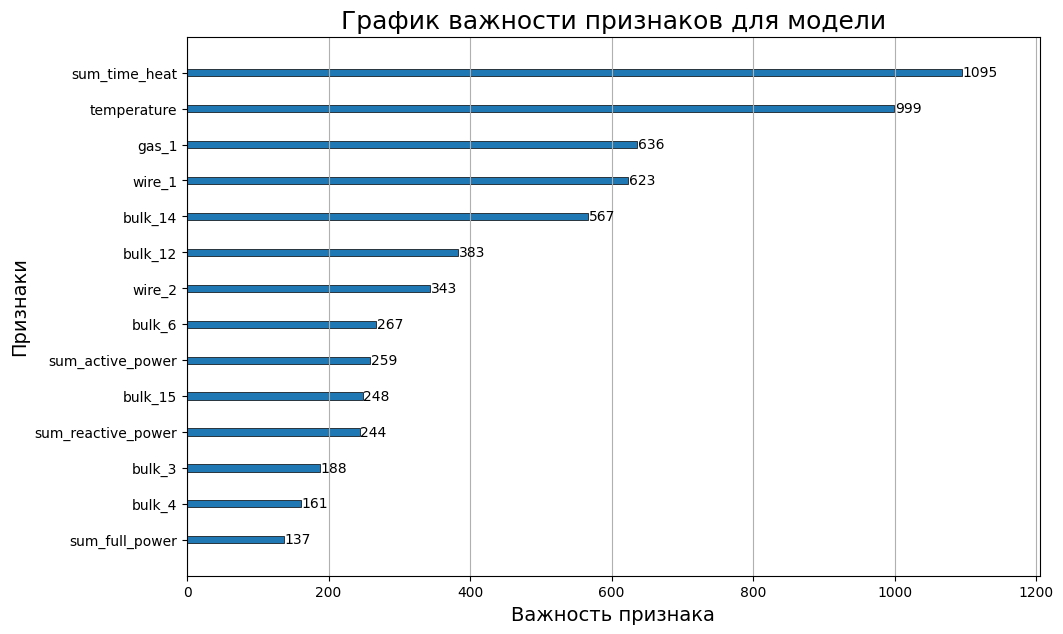

In [118]:
# Построим график важности признаков модели LGBMRegressor
lgb.plot_importance(best_lgbm_model, figsize=(11, 7), edgecolor='black', linewidth=0.5)

plt.title('График важности признаков для модели', fontsize=18)
plt.xlabel('Важность признака', fontsize=14)
plt.ylabel('Признаки', fontsize=14)
plt.grid(False, axis='y')
plt.show()

Итак, мы имеем график, на котором каждый признак представлен в виде горизонтальной полосы длиной, пропорциональной определённой важности (отображается количество раз, когда каждый признак использовался для разбиения данных во всех деревьях модели). На графике каждый признак показан в порядке убывания важности. Значения объектов с более высокой значимостью обладают большей прогностической силой.

Наиболее важными для модели `LGBMRegressor` являются следующие признаки (в порядке убывания важности):

- `sum_time_heat` — суммарное время нагрева для каждой партии;
- `temperature`	— показатель первой температуры сплава партии;
- `gas_1` — объём подаваемого газа для каждой партии;
- `wire_1` — объем подаваемого проволочного материала для каждой партии;
- `bulk_14` — объем подаваемого сыпучего материала для каждой партии;	


Для модели важно, чтобы вышеуказанные признаки были собраны корректно и данные были качественными, так как от них будет зависеть точность предсказаний последней температуры сплава. 

## Общий вывод.

В ходе выполнения проекта была проделана следующая работа:


**Проведен исследовательский анализ данных:**

 
- Наиболее часто в сплавы добавляются сыпучие материалы типа `bulk_3`, `bulk_4`, `bulk_6`, `bulk_12`, `bulk_14` и `bulk_15`. Тогда как сыпучие материалы прочих типов добавляются довольно редко и в совокупности применяются только в 16 % сплавов.

- Наиболее часто в сплавы добавляются проволочные материалы типа `wire_1` и `wire_2`. При этом тип `wire_1` добавляется практически во все сплавы (в 99%), а тип `wire_2` — в 1/3 всех сплавов. Типы проволочных материалов с `wire_2` по `wire_9` добавляют крайне редко и в совокупности применяются только в 7% сплавов. 

- Средние значения показателей при обработке стали:
   - температуры `temperature` сплава составляет 1590;
   - активной мощности `active_power` составляет 0.66;
   - реактивной мощности `reactive_power` составляет 0.49;
   - объема подаваемого газа `gas_1` составляет 11;

**Проведена предобработка данных:**


- Удалены аномальные значения температур ниже 1320 из столбца `temperature`.
- Удалено отрицательное значение реактивной мощности из столбца `reactive_power`.
- Пропуски в столбцах с `bulk_1` по `bulk_15` и с `wire_1` по `wire_2` заполнили значением `0`.


**Проведен отбор входящих признаков для обучения моделей:**



- Из датасета `data_temp` выделили два признака:
     - **целевой признак `target_temp`** — последняя температура сплава партии из исходного столбца `temperature`;
     - входящий признак `temperature` — первая температура сплава партии.


- Из исходных признаков дадасета `data_arc` созадали новые входящие признаки:
     - рассчитали значение полной мощности `full_power`  из признаков `active_power` и `reactive_power`;
     - рассчитали время нагрева `time_heat` для каждой партии из признаков `begin_heat` и `end_heat`;
     - рассчитали сумму значениий активной `sum_active_power`, реактивной `sum_reactive_power` и полной `sum_full_power` мощностей, а также суммарное время нагрева `sum_time_heat` для каждой партии. 


- В датасете `data_bulk` оставили только наиболее часто добавляемые в сплавы сыпучие материалы: столбцы `bulk_3`, `bulk_4`, `bulk_6`, `bulk_12`, `bulk_14` и `bulk_15`.
     
     
- В датасете `data_wire`оставили только наиболее часто добавляемые в сплавы проволочные материалы: столбцы `wire_1` и `wire_2`.


- В датасете `data_gas` использовали признак `gas_1` — объём подаваемого газа для каждой партии
     
 
- Создали один общий датасет `df_total` для обучения модели, объединив таблицы по ключу (столбец `key`). Общий датасет содержит данные, которые есть во всех исходных таблицах.



**Проведен исследовательский анализ признаков датасета `df_total`:**

- Целевой признак `target_temp` имеет нормальное распределение. Средний показатель последней температуры составляет 1593. 

- Признак `temperature` имеет нормальное распределение. Средний показатель температуры составляет 1588. Средний показатель первой температуры на 5 ниже среднего показателя последней температуры сплава (средний показатель 1588 у первого замера и 1593 у последнего).

- Признак `sum_active_power` (суммарная активная мощность) имеет распределение со смещением вправо. Среднее значение активной мощности составляет 0.66. 

- Признак `sum_reactive_power` (суммарная реактивная мощность) имеет распределение со смещением влево. Среднее значение суммарной реактивной мощности составляет 2.3. 

- Признак `sum_full_power` (суммарная полная мощность) имеет распределение со смещением вправо. Среднее значение суммарной полной мощности составляет 3.88. 

- Признак `sum_time_heat` (суммарное время нагрева) имеет распределение со смещением вправо. Среднее значение суммарного времени нагрева составляет 807.6. 

- Признак `gas_1` (объем подаваемого газа) имеет распределение со смещением вправо. Средний объем подаваемого газа равен 11. 

- Признаки `bulk_3`, `bulk_4`, `bulk_6`, `bulk_12`, `bulk_14` имеют асимметричное распределение с длинным правым хвостом. Большинство значений сосредоточено в нижней части диапазона (это заполненные пропуски значением `0`).

- Признак `bulk_15` имеет асимметричное распределение со смещением вправо. Выбросы отсутствуют. Имеются явные три группы скоплений наблюдений признака `bulk_15` у значений 0, 100 и 200 — это наиболее распространенные объемы подаваемого сыпучего материала. 

- Признак `wire_1` имеет распределение со смещением вправо, из-за заполнения пропусков значением `0`. Среднее значение составляет 102. 

- Распределение признака `wire_2` имеет асимметричное распределение с длинным правым хвостом. Большинство значений сосредоточено в нижней части диапазона (это заполненные пропуски значением `0`).

- Линейная и нелинейная зависимость входящих признаков `temperature`, `sum_active_power`, `sum_reactive_power`, `sum_full_power`, `sum_time_heat`, `gas_1`, `bulk_3`, `bulk_4`, `bulk_6`, `bulk_12`, `bulk_14`, `bulk_14`, `wire_1`, `wire_2` с целевым признаком **`target_temp`** отсутствует. 


**Проведен корреляционный анализ признаков:**


- Построили матрицу корреляции Спирмена. Коэффициенты корреляции Спирмена находятся в отрезке `[-1, 1]`, где `-1` — идеальная отрицательная связь (с ростом одной переменной другая уменьшается); `0` — нет связи; `1` — идеальная положительная связь (с ростом одной переменной другая увеличивается).

- Входящие признаки наиболее коррелирующие с целевым признаком `target_temp`:
   - `temperature` (коэф. 0.31) — показатель первой температуры сплава партии;
   - `wire_1` (коэф. 0.30) — объем подаваемого проволочного материала для каждой партии;
   - `bulk_6` (коэф. -0.26) — объем подаваемого сыпучего материала для каждой партии;
   - `sum_time_heat` (коэф. 0.24) — суммарное время нагрева для каждой партии;

- Входящие признаки `sum_active_power` и `sum_reactive_power` и `sum_full_power` являются *мультикоррелирующими* (коэф. больше 0.9), что негативно повлияет на обучение линейных моделей. Поэтому для обучения линейных моделей оставим признак `full_mean_power`, так как он содержит в себе показатели активной и реактивной мощностей. 




**Проведена подготовка данных для обучения моделей:**


- Для обучения модели `LinearRegression` исключили мультикоррелирующие входные признаки `sum_active_power` и `sum_reactive_power`. 
- Для обучения моделей градиентного бустинга `LGBMRegressor` использовали все доступные входные признаки.
- Для обеих моделей данные были разделены на тренировочную и тестовую выборки в соотношении 3:1.


**Проведено обучение моделей и выбор лучшей:**


- С помощью `GridSearchCV` перебрали для модели линейной регрессии `LinearRegression()` методы масштабирования признаков `StandardScaler, MinMaxScaler, passthrough`. Наилучшим образом справилась модель `LinearRegression()` без масштабирования прзнаков `passthrough`. Метрика `MAE` на кросс-валидации составила `6.35`.

- С помощью `OptunaSearchCV` подобрали для модели градиентного бустинга `LGBMRegressor` гиперпараметры максимальной глубины дерева, количество деревьев и скорости обучения. Мы получили модель `LGBMRegressor` со следующими гиперпараметрами: `'max_depth': 46, 'n_estimators': 205, 'learning_rate': 0.020850523701962827`. Метрика `MAE` на кросс-валидации модели составила `6.11`. 

- Наилучшей оказалась модель `LGBMRegressor` с метрикой `MAE` на кросс-валидации `6.11`.

- Метрика `MAE` модели `LGBMRegressor` на **тестовой выборке** составила `6.5`, для заказчика значение метрики `MAE` на тестовой выборке должно быть не больше `6.8`. Модель прошла проверку на адекватность: MAE константной модели на тестовой выборке выше на `1.5` чем у нашей лучшей модели. 


**Проведен анализ важности признаков модели `LGBMRegressor`:**


Наиболее важными для модели `LGBMRegressor` являются следующие признаки (в порядке убывания важности):

- `sum_time_heat` — суммарное время нагрева для каждой партии;
- `temperature`	— показатель первой температуры сплава партии;
- `gas_1` — объём подаваемого газа для каждой партии;
- `wire_1` — объем подаваемого проволочного материала для каждой партии;
- `bulk_14` — объем подаваемого сыпучего метериала для каждой партии;	


**Рекомендации для бизнеса:**

1. Для имитации технологического процесса обработки стали металлургический комбинат «Стальная птица» может использовать нашу модель `LGBMRegressor` со следующими гиперпараметрами: `'max_depth': 46, 'n_estimators': 205, 'learning_rate': 0.020850523701962827`. С её помощью можно будет предсказать последнюю температуру сплава партии.


2. Признаки ниже имеют высокую значимость для модели и обладают большей прогностической силой:

- `sum_time_heat` — суммарное время нагрева для каждой партии; 
- `temperature`	— показатель первой температуры сплава партии; 
- `gas_1` — объём подаваемого газа для каждой партии; 
- `wire_1` — объем подаваемого проволочного материала для каждой партии; 
- `bulk_14` — объем подаваемого сыпучего материала для каждой партии;

  Для модели важно, чтобы вышеуказанные признаки были собраны корректно и данные были качественными, так как от них в большей степени будет зависеть точность предсказаний последней температуры сплава.


3. Были выявлены типы сыпучих материалов, а также проволочных материалов, которые используются реже остальных при легировании стали:


   - `bulk_8` — данный тип сыпучего материала подавался только один раз;
   - `bulk_13` — данный тип сыпучего материала подавался только в 0.5% случаях;
   - `bulk_9` — данный тип сыпучего материала подавался только в 0.6% случаях;
   - `bulk_2` — данный тип сыпучего материала подавался только в 0.8% случаях;
   - `bulk_7` — данный тип сыпучего материала подавался только в 0.8% случаях;
   - `wire_5` — данный тип проволочного материала подавался только один раз;
   - `wire_7` — данный тип проволочного материала подавался только в 0.3% случаях;
   - `wire_4` — данный тип проволочного материала подавался только в 0.4% случаях;
   - `wire_8` — данный тип проволочного материала подавался только в 0.6% случаях;

   Возможно отказ от данных типов легирующих добавок поможет дополнительно уменьшить потребление электроэнергии на этапе обработки стали.